In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from decimal import Decimal
import pandas as pd
from scipy import stats as st
from scipy.optimize import curve_fit
import scipy.signal
from lmfit.models import GaussianModel
import scipy.interpolate as interp
import matplotlib.colors as colors



In [3]:
#Building Dictionary

myBins = np.linspace(-.45, 0.45, 1024)
stationList = [3.21, 3.38, 3.58, 3.80, 4.05, 4.33, 4.64, 5.01]
#stationList = [3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4, 4.6, 4.8, 5.]
#stationList = [3.2, 3.6, 4.0, 4.4, 4.8]
energyList = []

for thing in stationList:
    for num in np.arange(-0.08, 0.13, 0.04):
        energy = float(Decimal(str(thing)) + Decimal(str(num)))
        if energy == 3.3 or energy == 3.33 or energy == 3.7 or energy in energyList:
            continue
        else:
            energyList.append(energy)

binDic = {}
sumDic = {}
for bin in myBins:
    binDic[bin] = {}

def Gauss(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        ctr = params[i]
        amp = params[i + 1]
        wid = params[i + 2]
        y = y + amp * np.exp(-((x - ctr) / wid) ** 2)
    return y

##Specify Mosaic
#folder = "Continuous_Ef_Stations_Calibration"
#folder = "Energy Station Info Mosaic 360"
folder = "MANTA_Front-End_Calibration/8_Station"

if folder == "MANTA_Front-End_Calibration/8_Station":
    energyList += [4.52, 4.89]
    deadzones = [(0.115-0.45, 0.165-0.45), (0.22-0.45, 0.27-0.45),
            (0.325-0.45, 0.37-0.45), (0.435-0.45, 0.47-0.45), 
            (0.535-0.45, 0.58-0.45),(0.64-0.45, 0.685 -0.45),
            (0.75-0.45, 0.8-0.45)]
    energyList.sort()

#folder = "5_Ef_Calibration"
for Ei in energyList:
    #file = "Ei-" + str(Ei) + "TwoTh15psi0/"
    file = "Ei-" + str(Ei) + "/"
    try:
        os.chdir("D:/Users/Adit/MANTA_CAMEA/Toy_Model/" + folder + "/" + file)
    except:
        print("This Ei isn't there")
        print(Ei)
    dataPos = []
    dataIntensities = []
    for num in range(1, 8):
        try:
            a = open("ReuterStokes1_" + str(num) + "_1.psd")
            b = a.readlines()
            for line in b[46:]:
                j = line.split()
                loc = float(j[2])
                intensity = float(j[0]) * (10)
                dataPos.append(loc)
                if intensity > 0:
                    dataIntensities.append(intensity)
                else:
                    dataIntensities.append(0)
        except FileNotFoundError:
            continue
    for num in range(1, 7):
        try:
            a = open("ReuterStokes2_" + str(num) + "_1.psd")
            b = a.readlines()
            for line in b[46:]:
                j = line.split()
                loc = float(j[2])
                intensity = float(j[0]) * (10)
                dataPos.append(loc)
                if intensity > 0:
                    dataIntensities.append(intensity)
                else:
                    dataIntensities.append(0)
        except FileNotFoundError:
            continue
    #mean, std = st.norm.fit(data)
    oldData, oldbins = np.histogram(dataPos, bins = 1024, weights = dataIntensities, range = (-0.45, 0.45))
    #fittedData = st.norm.pdf(myBins, mean, std)

    #plt.hist(data, bins = myBins, alpha = 0.5, color = "g")
    #newData, thebins = np.histogram(fittedData, bins = 1024, range = (-0.45, 0.45))

    #data.sort()
    #data = np.array(data)

    #difference = data[1:] - data[:-1]
    #difference = difference[difference > 0.01]
    #Npks = len(difference) + 1

    #i_pk = scipy.signal.find_peaks_cwt(oldData, widths=range(1, len(myBins)))
    i_pk, _ = scipy.signal.find_peaks(oldData, prominence=75, distance = 50)

    fakePeakIndices = []
    for i in range(len(i_pk)):
        if i != (len(i_pk) -1):
            if i_pk[i+1] - i_pk[i] <= 10:
                fakePeakIndices.append(i)
    i_pk = np.delete(i_pk, fakePeakIndices)
    gaussMod = GaussianModel()
    pars = gaussMod.guess(data=oldData, x= myBins)
    modList = []
    for i in range(len(i_pk)):
        val = i_pk[i]
        gauss = GaussianModel(prefix='g' + str(i+1) + '_')
        pars.update(gauss.make_params())
        pars['g' + str(i+1) + '_center'].set(myBins[val])
        pars['g' + str(i+1) + '_sigma'].set(0.01)
        pars['g' + str(i+1) + '_amplitude'].set(oldData[val])
        modList.append(gauss)
    modArray = np.array(modList)
    mod = np.sum(modArray)
    init = mod.eval(pars, x=myBins)
    #plt.plot(myBins, init)
    out = mod.fit(oldData, pars, x=myBins)
    #plt.plot(myBins, out.best_fit)
    """
    oldData = np.array(oldData)
    oldbins = np.array(oldbins)
    dx = (np.max(myBins) - np.min(myBins))/float(Npks)
    #print(np.ravel([oldbins[i], oldData[i], dx] for i in i_pk))
    guess = []
    for i in i_pk:
        guess += [myBins[i], oldData[i], dx]
    #guess = np.ravel([oldbins[i], oldData[i], dx] for i in i_pk)
    #print(guess.dtype)
    popt, pcov = curve_fit(Gauss, myBins, oldData, p0=guess)
    #print(popt)
    otherFit = Gauss(oldbins, *popt)
    plt.plot(oldbins, otherFit)
    #print(len(data))
    #print(np.sum(fittedData))
    #plt.plot(myBins, fittedData)
    """
    #plt.title("Fits of Ei-" + str(Ei))
    #plt.xlabel("Detector Position (m)")
    #plt.ylabel("Detector Counts")
    #plt.show()

    #counts = np.bincount(out.best_fit)
    mySum = 0
    for index in range(0, len(myBins)):
        deadZoneChecker = False
        for tup in deadzones:
            if myBins[index] > tup[0] and myBins[index] < tup[1]:
                deadZoneChecker = True
        if deadZoneChecker == False:
            binDic[myBins[index]][Ei] = out.best_fit[index]
            mySum += out.best_fit[index]
        else:
            binDic[myBins[index]][Ei] = 0
    sumDic[Ei] = mySum
scaleDic = {}
maxEnergy = max(sumDic.values())
for akey in sumDic.keys():
    scaleDic[akey] = maxEnergy/sumDic[akey]
for akey in binDic.keys():
    for key2 in scaleDic.keys():
        binDic[akey][key2] = binDic[akey][key2] * scaleDic[key2]
proportionDic = {}
for akey in binDic.keys():
    proportionDic[akey] = {}
    sum = 0
    for e in binDic[akey].keys():
        sum += binDic[akey][e]
    for e in binDic[akey].keys():
        if sum == 0:
            proportionDic[akey][e] = 0
        else:
            proportionDic[akey][e] = binDic[akey][e]/sum
print("Proportion Dictionary built")


This Ei isn't there
3.34
Proportion Dictionary built


In [4]:
keyList = list(proportionDic.keys())
interval = keyList[1]-keyList[0]
mystep = interval/2
folder = "Official_Results"

def energyIntensity(Ei,Psi, fake):
    deltaElist = []
    #EfLister = [3.21, 3.38, 3.58, 3.8, 4.05, 4.33, 4.64, 5.01]
    infodict = {}
    events = {}
    for Ef in energyList:
        deltaE = Decimal(str(Ei))-Decimal(str(Ef))
        deltaE = float(deltaE)
        deltaElist.append(deltaE)
        infodict[deltaE] = 0
    ##Take this out as necessary
    #if Psi // 5 == Psi/5:
    #    Psi = int(Psi)
    #infodict = {3.79: 0, 3.62: 0, 3.42: 0, 3.2: 0, 2.95: 0, 2.67: 0, 2.36: 0, 1.99: 0}
    file = "Ei-" + str(Ei) + "TwoTh" + str(fake) + "psi" + str(Psi)  # + "Ei6"
    #file = "Ei" + str(Ei) + "Psi" + str(Psi) + "TwoTh" + str(fake)  # + "Ei6"
    #file = "TwoTh" + str(fake)
    try:
        os.chdir("D:/Users/Adit/MANTA_CAMEA/Full_MANTA/" + folder + "/" + file)
       # os.chdir("D:/Users/Adit/MANTA_CAMEA/Full_MANTA/" + file)
    except:
        print("this directory " + str(file) +' does not exist')
        return 0
    #ei=7
    try:
        c = open("maya.dat")
        d = c.readlines()
    except:
        print(file)
    #e = d[10]
    h = d[10].split('=')
    ang = float(h[-1])
    elist = []
    for channel in range(1, 9):
        for detArray in range(1,3):
            if detArray == 1:
                detNum = 7
                detAngList = np.array([-3.33, -2.22, -1.11, 0., 1.11, 2.22, 3.33])
            elif detArray == 2:
                detNum = 6
                detAngList = np.array([-2.775, -1.665, -0.55, 0.555, 1.665, 2.775])
            for det in range(detNum):
                realTwoTh = ang + ((channel-1) * 7.5) - detAngList[det]
        
                deltaElist = []
                #EfLister = [3.21, 3.38, 3.58, 3.8, 4.05, 4.33, 4.64, 5.01]
                infodict = {}
                events = {}
                for Ef in energyList:
                    deltaE = Decimal(str(Ei))-Decimal(str(Ef))
                    deltaE = float(deltaE)
                    deltaElist.append(deltaE)
                    infodict[deltaE] = 0
                try:
                    a = open(f"ReuterStokes{str(detArray)}_{str(det+1)}_{channel}.psd")
                    b = a.readlines()
                    for line in b[46:]:
                        j = line.split()
                        if len(j) == 4:
                            continue
                        #if float(j[2]) < 0.007 and float(j[2]) > -0.015:
                        #    print(j)
                        loc = float(j[2])
                        intensity = float(j[0])
                        for deadzone in deadzones:
                            if loc > deadzone[0] and loc < deadzone[1]:
                                intensity = 0
                        events[loc] = intensity
                except FileNotFoundError:
                    continue
                for event in events.keys():
                    #print(event)
                    minimizer = np.abs(np.array(keyList) - event)
                    #print(minimizer)
                    index = np.argmin(minimizer)
                    #index = np.where(minimizer == minimizer.min())
                    #print(float(index)
                    key = keyList[int(index)]
                    for energy in proportionDic[key].keys():
                        delE = float(Decimal(str(Ei)) - Decimal(str(energy)))
                        infodict[delE] += proportionDic[key][energy]* events[event]
                for akey in infodict.keys():
                    elist += [(realTwoTh, akey, infodict[akey])]
    painList = []
    #Ei = Ei/10000
    for entry in elist:
        ei = Ei
        ef = Decimal(str(Ei))-Decimal(str(entry[1]))
        ef = float(ef)
        twoth = entry[0]
        twoth = twoth
        wavelength = np.sqrt(81.8047/ei)
        ki = 2*np.pi/wavelength
        wavelength2 = np.sqrt(81.8047/ef)
        kf = 2*np.pi/wavelength2
        #scaleFactor = ki/kf
        #boy = 180-ang
        rad = twoth*np.pi/180 #converting to radians
        TwoTh_rad = rad
        #psi = 0
        Q = ki**2 + kf**2 - 2* ki * kf *np.cos(rad)
        Q = np.sqrt(Q)
        realpsi = (Psi*np.pi)/180
        psi_rad = realpsi
        Qx = ki*np.cos(-1*psi_rad) - kf*np.cos(-1*psi_rad+TwoTh_rad)
        Qy = ki*np.sin(-1*psi_rad) - kf*np.sin(-1*psi_rad+TwoTh_rad)
        #realpsi = 0
        #Qx = math.sin(-realpsi-rad/2)*Q
        #*math.sin(rad/2)
        #Qy = math.cos(-realpsi-rad/2)*Q
        #*math.cos(rad/2)
        nCount = entry[2]
        nCount = nCount * ki/kf
        painList.append((Psi, entry[1], nCount, ang, Qx, Qy))
        #a = 6.28
        #h = Qx*a/(2*math.pi)
        #k = Qy*a/(2*math.pi)
        #painList.append((Psi, entry[1], entry[2], ang, h, k))
    return painList


In [5]:
#format of tup in tuplist ((Q, etransferred, ncount, ang, Qx, Qy))
tuplist = []
#Eilist = [4,5.5,7,8.5,10,11.5,13]
#Eilist = [4, 5.5, 7, 8.5, 10, 11.5]
EiList = [5.1,5.27]
#TwoThList = [6, 8, 10, 60, 62, 64, 66, 68, 112, 114, 116, 118, 120]
TwoThList = [6, 8, 10, 60, 62, 64, 66, 68, 112, 114, 116, 118]
for Ei in EiList:
    for twoth in TwoThList:
    #    for boy in range(0, 91, 5):
    #will need to swap this out depending on if its a float or not 
        for boy in np.arange(0,361.0, 2.5):
        #for boy in range(0,361, 5):
            #num = int(num*10)/100
            boy = float(boy)
            values = energyIntensity(Ei, boy, twoth)
            if type(values) == list:
                tuplist += values

#print(tuplist)
tuplist.sort()

this directory Ei-5.1TwoTh6psi360.0 does not exist
this directory Ei-5.1TwoTh8psi360.0 does not exist
this directory Ei-5.1TwoTh10psi360.0 does not exist
this directory Ei-5.1TwoTh60psi360.0 does not exist
this directory Ei-5.1TwoTh62psi360.0 does not exist
this directory Ei-5.1TwoTh64psi360.0 does not exist
this directory Ei-5.1TwoTh66psi360.0 does not exist
this directory Ei-5.1TwoTh68psi360.0 does not exist
this directory Ei-5.1TwoTh112psi360.0 does not exist
this directory Ei-5.1TwoTh114psi360.0 does not exist
this directory Ei-5.1TwoTh116psi360.0 does not exist
this directory Ei-5.1TwoTh118psi360.0 does not exist
this directory Ei-5.27TwoTh6psi360.0 does not exist
this directory Ei-5.27TwoTh8psi360.0 does not exist
this directory Ei-5.27TwoTh10psi360.0 does not exist
this directory Ei-5.27TwoTh60psi360.0 does not exist
this directory Ei-5.27TwoTh62psi360.0 does not exist
this directory Ei-5.27TwoTh64psi360.0 does not exist
this directory Ei-5.27TwoTh66psi360.0 does not exist
this 

In [6]:
tuplist = sorted(tuplist, key = lambda x: x[2])
print(tuplist[-2:])

[(22.5, -0.03, 1326058.9740129428, 112.0, 1.9675090666122723, -2.0860561904640678), (197.5, 0.14, 1588062.6393959802, 112.0, -1.9883284279957305, 1.9819737957080696)]


In [7]:

Qxlist = []
Qylist = []
newzlist = []
neutroncountlist = []
#xlist1 = []
ylist = []
zlist = []
zlist3 = []
for tup in tuplist:
    #if tup[2] >0:
     if True:
        #xlist1 += [tup[0]]
        ylist += [tup[1]]
        zlist += [tup[2]]
        Qxlist += [tup[-2]]
        Qylist += [tup[-1]]
        newzlist += [tup[1]]
        neutroncountlist += [tup[2]]
    #zlist3.append((tup[1], tup[2]))
pray = []

testNeutronCountList = np.array(neutroncountlist)
allNeutrons = np.sum(testNeutronCountList)
print("this is all my neutrons")
print(allNeutrons)
#print(min(Qylist))
#print(max(Qxlist))
#print(max(Qylist))
#print(pray)
#print(len(newzlist))
hugeDict = {}

Eflist = energyList
Etransferredlist = []
for Ei in EiList:
    for Ef in Eflist:
        delta = Decimal(str(Ei)) - Decimal(str(Ef))
        delta = float(delta)
        Etransferredlist.append(delta)
Etransferredlist.sort(reverse=True)
for num in range(0,301, 5):
    num = num/100
    hugeDict[num] = {}
for key in hugeDict.keys():
    for num in range(0,301,5):
        num = num/100
        hugeDict[key][num] = {}
for key in hugeDict.keys():
    for man in hugeDict[key].keys():
        for e in Etransferredlist:
            hugeDict[key][man][e] = 0

finallist = []
Qxlist22 = []
Qylist22 = []
for value in hugeDict[0].keys():
    Qxlist22.append(value)
for value in hugeDict.keys():
    Qylist22.append(value)
Qxlist22.sort()
Qylist22.sort()
"""
for key in Qylist22:
    for man in Qxlist22:
        for tup in tuplist:
            if tup[5] > key - 0.025 and tup[5] < key + 0.025:
                if tup[4] > man -.025 and tup[4] < man+0.025:
                    hugeDict[man][key][tup[1]] += tup[2]
            #print(tup)
            #print(bigdict[key][tup[1]])
            #hugeDict[key][tup[1]] += tup[2]

#print(hugeDict[0])
"""

this is all my neutrons
3497275886.6460657


'\nfor key in Qylist22:\n    for man in Qxlist22:\n        for tup in tuplist:\n            if tup[5] > key - 0.025 and tup[5] < key + 0.025:\n                if tup[4] > man -.025 and tup[4] < man+0.025:\n                    hugeDict[man][key][tup[1]] += tup[2]\n            #print(tup)\n            #print(bigdict[key][tup[1]])\n            #hugeDict[key][tup[1]] += tup[2]\n\n#print(hugeDict[0])\n'

16529272


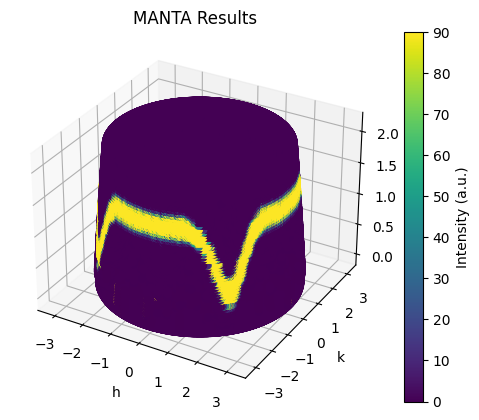

In [8]:

#print(finallist)
fig = plt.figure()
ax = plt.axes(projection='3d')
print(len(newzlist))
#p = ax.scatter(Qxlist, Qylist, newzlist, s=60, c=neutroncountlist, norm =colors.LogNorm(vmin = 1, vmax = 500))
p = ax.scatter(Qxlist, Qylist, newzlist, s=20, c=neutroncountlist, vmax = 90)
plt.title("MANTA Results")

plt.xlabel("h")
plt.ylabel("k")
ax.set_zlabel("${\Delta}$ E (meV)")
fig.colorbar(p, label = "Intensity (a.u.)")
plt.show()
#test = []
#for key in hugeDict[0][0].keys():
#    test.append(key)


In [9]:
#format of tup in tuplist ((Q, etransferred, ncount, ang, Qx, Qy))
from datetime import date
today = date.today()
def sliceGenerator(var, value, width):
    #first order is Qy
    #Second order is Qx
    #Third order is Energy Transferred
    datalist = []
    #Qxlist22.sort(reverse=True)
    #Etransferredlist.sort(reverse=True)
    bigdict = {}
    if var == "Qy":
        #fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (13, 5))
        fig, ax1 = plt.subplots(1, figsize = (6, 5))
        #for num in range(-240, 240, 5):
        #    num = num / 100
        #    bigdict[num] = {}
        #    for e in Etransferredlist:
        #        bigdict[num][e] = 0
        #for key in bigdict.keys():
        #    for tup in tuplist:
        #        if tup[-1] <= value+width and tup[-1] >= value-width:
        #            if tup[-2] > key - 0.025 and tup[-2] < key + 0.025:
                    # print(tup)
                    # print(bigdict[key][tup[1]])
        #                if tup[2] > 50:
        #                    bigdict[key][tup[1]] += 0
        #                else:
        #                    bigdict[key][tup[1]] += tup[2]
        #xlist = []
        #for key in bigdict.keys():
        #    xlist.append(key)
        #xlist.sort()

        #finallist = []
        #for thing in Etransferredlist:
        #    thislist = []
        #    for num in xlist:
        #        thislist.append(bigdict[num][thing])
        #    finallist.append(thislist)
        #xmin = min(xlist)
        #xmax = max(xlist)
        #ymin = min(Etransferredlist)
        #ymax = max(Etransferredlist)
        #print("Below is ymax")
        #print((xmin, xmax))
        """
        for e in Etransferredlist:
            thislist = []
            for qx in Qxlist22:
                thislist.append(hugeDict[qx][value][e])
            datalist.append(thislist)
        """


        xboys = []
        yboys = []
        zboys = []
        x2dHist = []
        y2dHist = []
        for tup in tuplist:
            if tup[-1] <= value+width and tup[-1] >= value-width:
                xboys += [tup[-2]]
                yboys += [tup[1]]
                zboys += [tup[2]]
                
                tempx2dHist= [tup[-2]] * round(tup[2])
                x2dHist += tempx2dHist
                y2dHist += [tup[1]] * round(tup[2])
        #plt.scatter(xboys,yboys, s=60, c=zboys)

        #plt.show()
        a = ax1.scatter(xboys, yboys, s= 8, c=zboys, vmax=4000)
        #ax1.set_xlim(-1.8, 1.)
        ax1.set_ylabel("${\Delta}$E (meV)")
        ax1.set_xlabel("$Q_x$ $(\AA^{-1})$")
        ax1.set_xlim(-2.6, 2.6)
        ax1.set_ylim(0, 2.2)
        ax1.set_title(r"MANTA Phonon Dispersion ($Q_x$,  $Q_y$ = " + str(value) + " $\pm$ " + str(width) + " $\AA^{-1}$)")
        plt.colorbar(a, label="Intensity (a.u)", ax=ax1)
        mylist = []
        #print(datalist)
    
        #i = len(finallist) - 1

        #while i > -1:
        #    mylist.append(finallist[i])
        #    i -= 1
        
        #x = np.linspace(xmin, xmax, len(thislist))
        #y = np.linspace(ymin, ymax, len(Etransferredlist))
        #mylist = np.array(mylist)
        #finallist = np.array(finallist).T
        #f = interp.interp2d(x, y, mylist)
        #xnew = np.arange(xmin, xmax, 1e-2)
        #ynew = np.arange(ymin, ymax, 1e-2)
        #znew = f(xnew, ynew)
        #plt.xlabel("h")
        # ax.set_title("Slice of Qx = " + str(value))
        #b = ax2.pcolormesh(xnew, ynew, znew, norm = colors.LogNorm(vmin = 0.01, vmax = 500))
        #b = ax2.pcolormesh(xnew, ynew, znew)
        #b = ax2.pcolormesh(x, y, mylist, shading= 'gouraud')
        
        
        #b = ax2.hist2d(x2dHist, y2dHist, bins = 70)
        #ax2.set_title("Interpolated Data")
        #ax2.set_ylabel("${\Delta}$E")
        #fig.suptitle(r"Slice of (h,  " + str(value) + ", 0) 8 Station Full MANTA Ei-5.27")
        #plt.colorbar(b, label="Neutron Count", ax = ax2)
        path = f"D:/Users/Adit/Figures/2024 Updated Figures/Detector_Different_2theta/MANTA Qy Slice {value} One Ei {today}.pdf"
        if os.path.isfile(path):
            print("File exists! Pick a new name")
        else:
            plt.savefig(path, format="pdf")
        plt.show()
                      
        return (xboys, yboys, zboys)
        
        
        """
        b = ax2.imshow(znew, extent=[xmin, xmax, ymin, ymax], aspect='auto', interpolation='bilinear')
        ax2.set_title("Interpolated Data")
        ax2.set_ylabel("${\Delta}$E")
        fig.suptitle("Slice of ($Q_x$,  " + str(value) + ", 0) 8 Station Full MANTA Ei-5.1")
        plt.colorbar(b, label="Neutron Count")
        plt.show()
        """
        
        #plt.xlabel("Qx")
        #plt.ylabel("Etransferred")
        #plt.title("Slice of Qy = " + str(value))
        #plt.imshow(znew, extent = [xmin,xmax,ymin,ymax], aspect = 'auto', interpolation='bilinear')
        #plt.colorbar(label="Neutron Count")
        #plt.show()
        # format of tup in tuplist ((Q, etransferred, ncount, ang, Qx, Qy))
    if var == "Qx":
        #fig, ax = plt.subplots()
        fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True)

        for num in range(-320, 320, 20):
            num = num / 100
            bigdict[num] = {}
            for e in Etransferredlist:
                bigdict[num][e] = 0
        for key in bigdict.keys():
            for tup in tuplist:
                if tup[-2] <= value+.1 and tup[-2] >= value-0.1:
                    if tup[-1] > key - 0.1 and tup[-1] < key + 0.1:
                        # print(tup)
                        # print(bigdict[key][tup[1]])
                        bigdict[key][tup[1]] += tup[2]
        xlist = []
        for key in bigdict.keys():
            xlist.append(key)
        xlist.sort()
        finallist = []
        for thing in Etransferredlist:
            thislist = []
            for num in xlist:
                thislist.append(bigdict[num][thing])
            finallist.append(thislist)
        xmin = min(xlist)
        xmax = max(xlist)
        ymin = min(Etransferredlist)
        ymax = max(Etransferredlist)
        """
        for e in Etransferredlist:
            thislist = []
            for qx in Qxlist22:
                thislist.append(hugeDict[qx][value][e])
            datalist.append(thislist)
        """

        xboys = []
        yboys = []
        zboys = []
        for tup in tuplist:
            if tup[-2] <= value+.05 and tup[-2] >= value-0.05:
                xboys += [tup[-1]]
                yboys += [tup[1]]
                zboys += [tup[2]]
        a = ax1.scatter(xboys, yboys, s=60, c=zboys)
        ax1.set_ylabel("${\Delta}$E (meV)")
        ax1.set_xlabel("k " + str(value))
        ax1.set_title("Data Points")
        plt.colorbar(a, label = "Neutron Count", ax = ax1)
        #plt.show()
        mylist = []
        # print(datalist)
        """
        i = len(datalist) - 1
        print(datalist)
        while i > -1:
            mylist.append(datalist[i])
            i -= 1
        """
        x = np.linspace(xmin, xmax, len(thislist))
        y = np.linspace(ymin, ymax, len(Etransferredlist))
        f = interp.interp2d(x, y, finallist)
        xnew = np.arange(xmin, xmax, 1e-2)
        ynew = np.arange(ymin, ymax, 1e-2)
        znew = f(xnew, ynew)
        plt.xlabel("Qy " + r'$\AA$')
        #ax.set_title("Slice of Qx = " + str(value))
        b = ax2.imshow(znew, extent=[xmin, xmax, ymin, ymax], aspect='auto', interpolation='bilinear')
        ax2.set_title("Interpolated Data")
        ax2.set_ylabel("${\Delta}$E")
        fig.suptitle("Slice of Qx = " + str(value) + " $\pm$ 0.05 " + r'$\AA^-1$ with New Analysis Method' )
        plt.colorbar(b, label="Neutron Count")
        plt.show()
    # format of tup in tuplist ((Q, etransferred, ncount, ang, Qx, Qy))
    if var == "Etransferred":
        xmin = min(Qxlist)
        xmax = max(Qxlist)
        ymin = min(Qylist)
        ymax = max(Qylist)

        for key in hugeDict.keys():
            thislist = []
            for key2 in hugeDict[key].keys():
                for key3 in hugeDict[key][key2].keys():
                    if key3 <= value +width and key3 >= value - 0.05:
                        thislist.append(hugeDict[key][key2][key3])
            datalist.append(thislist)
        for num in range(-300, 300, 10):
            num = num / 100
            bigdict[num] = {}
            for boyo in range(-300, 300, 10):
                boyo = boyo / 100
                bigdict[num][boyo] = 0
        #boyo = y
        #num =x
        for tup in tuplist:
            if tup[1] <= value+width and tup[1]>= value -width:
                for akey in bigdict.keys():
                    if tup[-2] >= akey -0.05 and tup[-2] <= akey +0.05:
                        for thiskey in bigdict[akey].keys():
                            if tup[-1] >= thiskey -0.05 and tup[-1] <= thiskey +0.05:
                                if tup[2] > 700:
                                    bigdict[akey][thiskey] += np.nan
                                else:
                                    bigdict[akey][thiskey] += tup[2]
        """
        for akey in bigdict.keys():
            for thiskey in bigdict[akey].keys():
                if bigdict[akey][thiskey] == 0:
                    bigdict[akey][thiskey] = np.nan
        """
        #print(bigdict)
        xlist = []
        for key in bigdict.keys():
            xlist.append(key)
        xlist.sort()
        ylist = []
        for key in bigdict[0].keys():
            ylist.append(key)
        ylist.sort()
        finallist = []
        #print(bigdict.keys())
        for thing in ylist:
            thislist = []
            for num in xlist:
                thislist.append(bigdict[num][thing])
            finallist.append(thislist)
        xmin = min(xlist)
        xmax = max(xlist)
        ymin = min(ylist)
        ymax = max(ylist)

        """
        for num in range(15, 320, 10):
            num = num / 100
            bigdict[num] = {}
            for soup in range(15,320, 10):
                bigdict[num][soup] = 0
        for key in bigdict.keys():
            for tup in tuplist:
                if tup[-2] <= value+.05 and tup[-2] >= value-0.05:
                    if tup[-1] > key - 0.05 and tup[-1] < key + 0.05:
                        # print(tup)
                        # print(bigdict[key][tup[1]])
                        bigdict[key][tup[1]] += tup[2]
        """
        xboys = []
        yboys = []
        zboys = []
        magQlist =[]
        # format of tup in tuplist ((Q, etransferred, ncount, ang, Qx, Qy))
        mymin = 0
        mymax = 0
        thisxmin = 0
        thisxmax = 0
        thisymin = 0
        thisymax = 0
        for tup in tuplist:
            if tup[2] > mymax:
                mymax = tup[2]
            if tup[-2] < thisxmin:
                thisxmin = tup[-2]
            if tup[-2] > thisxmax:
                thisxmax = tup[-2]
            if tup[-1] < thisymin:
                thisymin = tup[-1]
            if tup[-1] > thisymax:
                thisymax = tup[-1]
            if tup[1] <= value + width and tup[1] >= value - width:
                #if tup[-2] > 1 and tup[-1] > -2 and tup[-1] < -1:
                if True:
                    #if False:
                    #if tup[0] == 72.5 or tup[0] == 75.0 or tup[0] == 100:
                    #    if tup[-3] == 118.0 or tup[-3] == 120.0:
                    #        continue
                    #else:
                    xboys += [tup[-2]]
                    yboys += [tup[-1]]
                    zboys += [tup[2]]
                    #if tup[2] == 0:
                        #print(tup)
            #zboys += [tup[0]]
                    magQ = np.sqrt(tup[-1]**2 + tup[-2]**2)
                    magQlist.append(magQ)
        #print(mymax)

        #a = plt.scatter(xboys, yboys, s=27, c=zboys, vmin=0, vmax=mymax)
        a = plt.scatter(xboys, yboys, s=1, c=zboys, vmin=0, vmax = 5000)
        #axes = a.add_axes([.1, .1, .8, .8])
        #a.set_xlim([-3.1,3.1])
        #plt.xlim(thisxmin, thisxmax)
        #plt.xlim(-3.2, 3.2)
        #plt.ylim(-3.2, 3.2)
        #plt.ylim(thisymin, thisymax)
        #plt.xlabel("$Q_x$ $(\AA^{-1})$")
        #plt.ylabel("$Q_y$ $(\AA^{-1})$")
        #plt.colorbar(label="Neutron Count")
        plt.colorbar()
        #norm = colors.Normalize(vmin=0, vmax=mymax)
        #plt.title("MANTA Phonon Dispersion ($Q_x$, $Q_y$) ${\Delta}$E = " + str(value) + " $\pm$ " + str(width) + ' meV')
        path = f"D:/Users/Adit/Figures/2024 Updated Figures/Detector_Different_2theta/MANTA E Slice {value} {today}.pdf"
        if os.path.isfile(path):
            print("File exists! Pick a new name")
        else:
            plt.savefig(path, format="pdf")
        plt.show()
        x = np.linspace(xmin, xmax, len(thislist))
        y = np.linspace(ymin, ymax, len(finallist))
        f = interp.interp2d(x, y, finallist)
        f = interp.interp2d(x, y, finallist)
        xnew = np.arange(xmin, xmax, 1e-2)
        ynew = np.arange(ymin, ymax, 1e-2)
        znew = f(xnew, ynew)
        #print(magQlist)

        mylist = []
        i = len(finallist) - 1
        while i > -1:
            mylist.append(finallist[i])
            i -= 1

        plt.xlabel("h")
        plt.ylabel("k")
        plt.title("Slice of ${\Delta}$E = " + str(value) + " $\pm$ " + str(width) + " 8 Station Full MANTA")
        plt.imshow(mylist, extent=[xmin, xmax, ymin, ymax], aspect='auto', interpolation='bilinear')
        plt.colorbar(label="Neutron Count")
        
        plt.show()
        return (xboys, yboys, zboys)

In [10]:
#format of tup in tuplist ((Q, etransferred, ncount, ang, Qx, Qy))
from lmfit.models import *


def Gauss(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        ctr = params[i]
        amp = params[i + 1]
        wid = params[i + 2]
        y = y + amp * np.exp(-((x - ctr) / wid) ** 2)
    return y

def sliceGenerator1D(parameter, qxVal, qyVal, eTransferredVal):
    xAxisScatter = []
    yAxisScatter = []
    pairs = []      
    bigdict = {}
    if parameter == "Qx":
        for num in range(0, 201, 10):
            num = num / 100
            bigdict[num] = 0
        #for tup in tuplist:
        #    if tup[-1] <= (qyVal + 0.025) and tup [-1] >= (qyVal - 0.025):
        #        if tup[1] <= (eTransferredVal + 0.05) and tup[1] >= (eTransferredVal -0.05):
        #           xAxisScatter.append(tup[-2])
        #           yAxisScatter.append(tup[2])
        #           pairs.append((tup[-2], tup[2]))
        for key in bigdict:
            for tup in tuplist:
                    if tup[1] <= eTransferredVal+.05 and tup[1] >= eTransferredVal-0.05:
                        if tup[-1] > qyVal - 0.1 and tup[-1] < qyVal + 0.1:
                        # print(tup)
                        # print(bigdict[key][tup[1]])
                            if tup[-2] <= key +0.05 and tup[-2] >= key - 0.05:
                                bigdict[key] += tup[2]

        xAxisScatter = []
        yAxisScatter = []                        
        
        for key in bigdict:
            xAxisScatter.append(key)
            yAxisScatter.append(bigdict[key])
        
        xAxisScatter = np.array(xAxisScatter)
        yAxisScatter = np.array(yAxisScatter)
        plt.xlabel("$Q_x$")
        plt.ylabel("Intensity (a.u.)")
        plt.scatter(xAxisScatter, yAxisScatter, marker = "x")
        #plt.show()
        pairs.sort()

    

        i_pk, _ = scipy.signal.find_peaks(yAxisScatter, prominence=10, distance=4)
        
        """
        for i in range(len(i_pk)):
            if i != (len(i_pk) -1):
                if i_pk[i+1] - i_pk[i] <= 2:
                    fakePeakIndices.append(i)
        print(i_pk)
        print(fakePeakIndices)
        i_pk = np.delete(i_pk, fakePeakIndices)
        """
        #print(i_pk)
        test = i_pk[1]
        #print(xAxisScatter[test])
        gaussMod = GaussianModel()
        pars = gaussMod.guess(data=yAxisScatter, x= xAxisScatter)
        #print(pars)
        modList = []
        for i in range(len(i_pk)):
            val = i_pk[i]
            gauss = GaussianModel(prefix='g' + str(i+1) + '_')
            pars.update(gauss.make_params())
            pars['g' + str(i+1) + '_center'].set(xAxisScatter[val])
            pars['g' + str(i+1) + '_sigma'].set(0.1)
            pars['g' + str(i+1) + '_amplitude'].set(yAxisScatter[val])
            #pars['g' + str(i+1) + '_expon'].set(1.5)
            modList.append(gauss)
        modArray = np.array(modList)
        mod = np.sum(modArray)
        init = mod.eval(pars, x=xAxisScatter)
        #plt.plot(myBins, init)
        out = mod.fit(yAxisScatter, pars, x=xAxisScatter)
        #print(out.fit_report())
        plt.plot(xAxisScatter, out.best_fit)
        #for thing in pairs:
         #   xAxisScatter.append(thing[0])
         #   yAxisScatter.append(thing[1])
        
        xAxisScatter = np.array(xAxisScatter)
        yAxisScatter = np.array(yAxisScatter)
        #plt.plot(xAxisScatter, yAxisScatter)
        plt.xlabel("h")
        plt.ylabel("Intensity (a.u.)")
        plt.title("8 Station Full MANTA Mosaic 60 $\Delta E = $" +str(eTransferredVal) + " $\pm 0.05$ meV, k $ = $ " + str(qyVal) + ' $\pm 0.1$')
        plt.title
        plt.show()
        return out.best_values
      
    if parameter == "Qy":
        print("Not Ready Yet")
    if parameter == "Etransferred":
        for num in range(2, 210, 4):
            num = num / 100
            bigdict[num] = 0
    # format of tup in tuplist ((Q, etransferred, ncount, ang, Qx, Qy))
        for key in bigdict.keys():
            for tup in tuplist:
                if tup[-1] <= qyVal+.1 and tup[-1] >= qyVal-0.1:
                    if tup[-2] > qxVal - 0.05 and tup[-2] < qxVal + 0.05:
                    # print(tup)
                    # print(bigdict[key][tup[1]])
                        if tup[1] <= key +0.02 and tup[1] >= key - 0.02:
                            bigdict[key] += tup[2]
        for tup in tuplist:
            if tup[-1] <= (qyVal + 0.1) and tup[-1] >= (qyVal - 0.1):
                if tup[-2] <= (qxVal + 0.05) and tup[-2] >= (qxVal - 0.05):
                   xAxisScatter.append(tup[1])
                   yAxisScatter.append(tup[2])
                   pairs.append((tup[1], tup[2]))
        plt.xlabel("$\Delta E  (meV)$")
        plt.ylabel("Intensity (a.u)")

        #plt.show()
        pairs.sort()
        xAxisScatter = []
        yAxisScatter = []
        for key in bigdict:
            xAxisScatter.append(key)
            yAxisScatter.append(bigdict[key])
        xAxisScatter = np.array(xAxisScatter)
        yAxisScatter = np.array(yAxisScatter)
        plt.scatter(xAxisScatter, yAxisScatter, marker = "x")
        gaussMod = GaussianModel()
        pars = gaussMod.guess(data=yAxisScatter, x= xAxisScatter)
        #mod = 
        init = gaussMod.eval(pars, x=xAxisScatter)
        #plt.plot(myBins, init)
        out = gaussMod.fit(yAxisScatter, pars, x=xAxisScatter)
        x = np.linspace(0, 2, 300)
        amp, cent, sigma = out.best_values['amplitude'], out.best_values['center'], out.best_values['sigma']
    
        y = amp/(np.sqrt(2*np.pi)*sigma) * np.exp(-((x-cent)**2)/(2* (sigma**2)))
        #plt.plot(xAxisScatter, out.best_fit)
        plt.plot(x, y)
        #plt.plot(xAxisScatter, yAxisScatter)
        #plt.xlim(1., 2.)
        #print(out.best_values)
        plt.title("8 Station Full MANTA Mosaic 60 h = " + str(qxVal) + " $\pm 0.05 $ k = " + str(qyVal) + " $\pm 0.1$ Cut ")
        plt.show()
        return out.best_values

File exists! Pick a new name


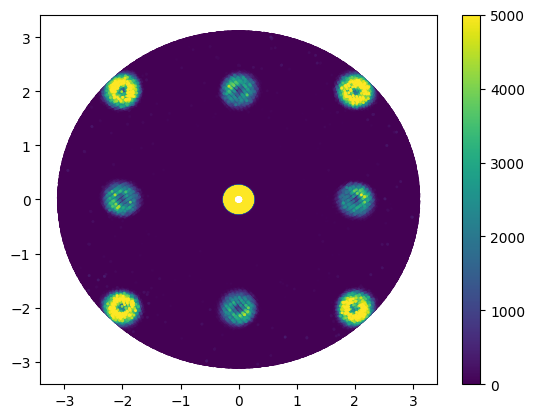

C:\Users\Administrator\AppData\Local\Temp\ipykernel_17872\2032739811.py:346: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interp.interp2d(x, y, finallist)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17872\2032739811.py:347: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new

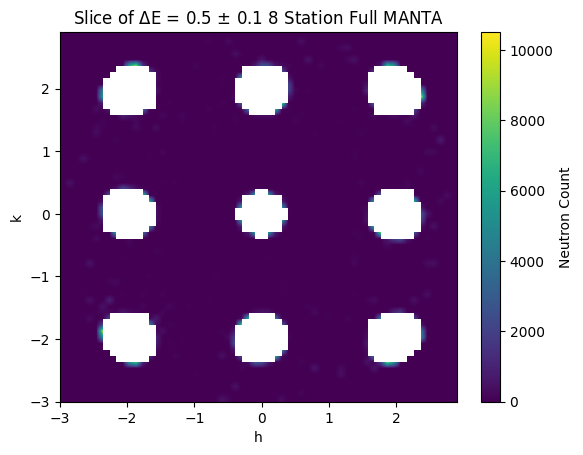

File exists! Pick a new name


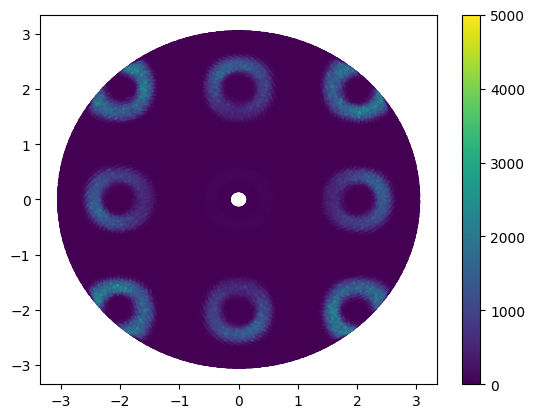

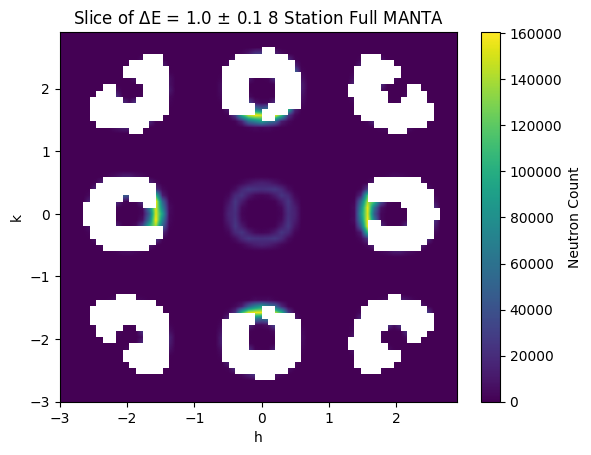

File exists! Pick a new name


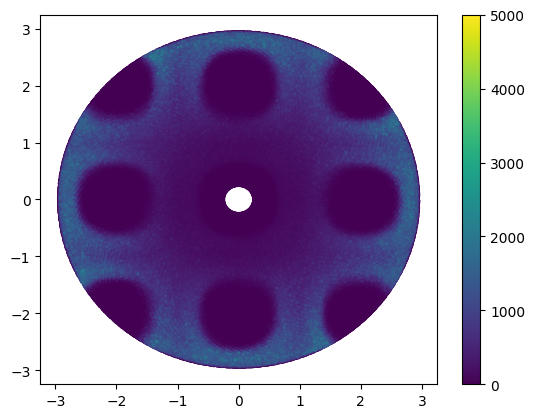

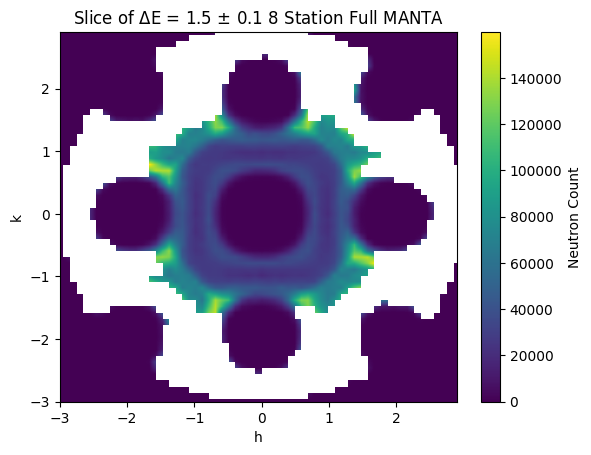

([0.23493259171559266,
  0.23561064623313221,
  0.23641622868526313,
  0.23734926348495144,
  0.23840966308643097,
  0.23959732799341782,
  0.24091214676844497,
  0.24938881388156098,
  0.23797409354956311,
  0.23911132361495047,
  0.24125328750196084,
  0.24191525938644332,
  0.24270173439715226,
  0.2436126387398867,
  0.24203358035096878,
  0.24270809408964622,
  0.24350946981614618,
  0.24443763233814741,
  0.24549249456704514,
  0.24667395752612187,
  0.24798191035983375,
  0.2494027448391194,
  0.25641431259017233,
  0.2584782129418359,
  0.24505919956027666,
  0.2461904910468733,
  0.25197976986892545,
  0.2597846848307055,
  0.2548672995400385,
  0.2589215562757934,
  0.2485277340662233,
  0.2491860786802016,
  0.24996824420636066,
  0.25087415725485407,
  0.251903732824724,
  0.2530568743118762,
  0.25433347351814306,
  0.25572024842450203,
  0.2589027617796835,
  0.26067187837743866,
  0.2625637381857342,
  0.2645781636931668,
  0.2514808245611666,
  0.25258499726267547,
  0.

In [57]:
#sliceGenerator("Qy", 0.45, 0.1)
#print(sliceGenerator1D("Qx", "N/A", -2, 1.0))
#sliceGenerator("Qy", -2, 0.1)
sliceGenerator("Etransferred", 0.5, 0.1)
sliceGenerator("Etransferred", 1.0, 0.1)
sliceGenerator("Etransferred", 1.5, 0.1)


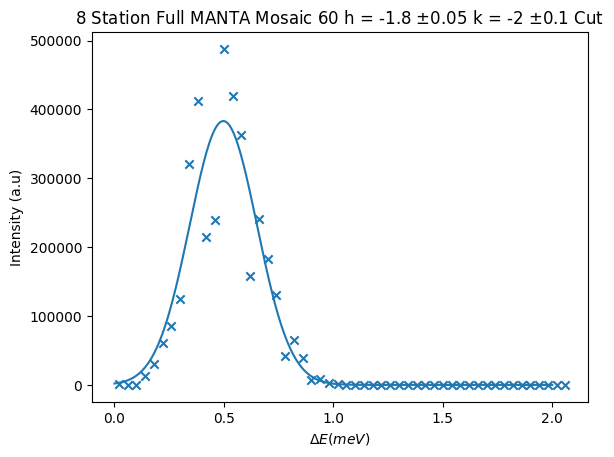

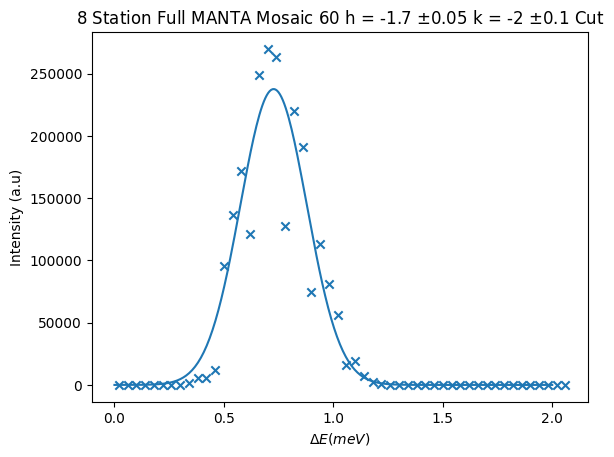

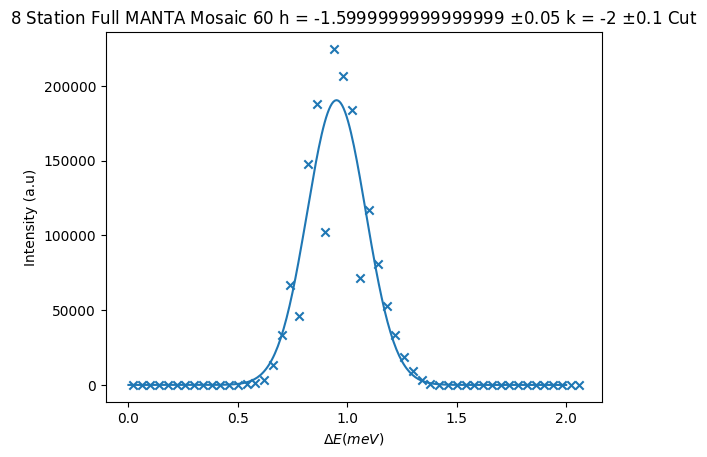

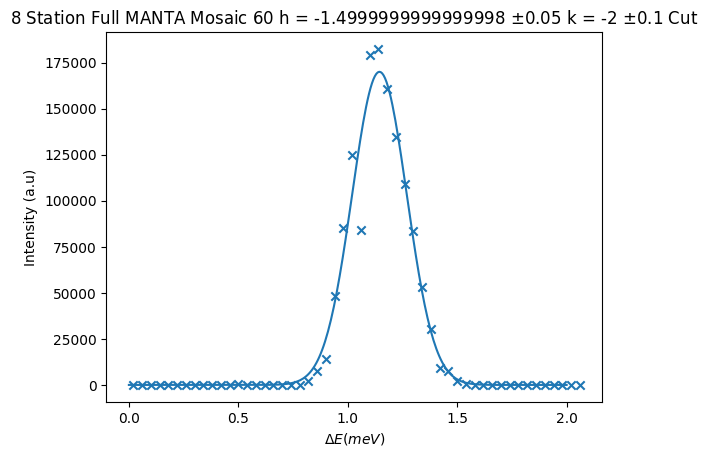

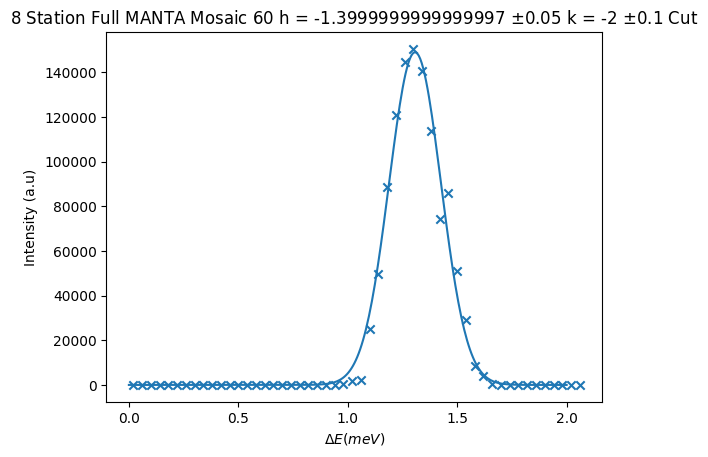

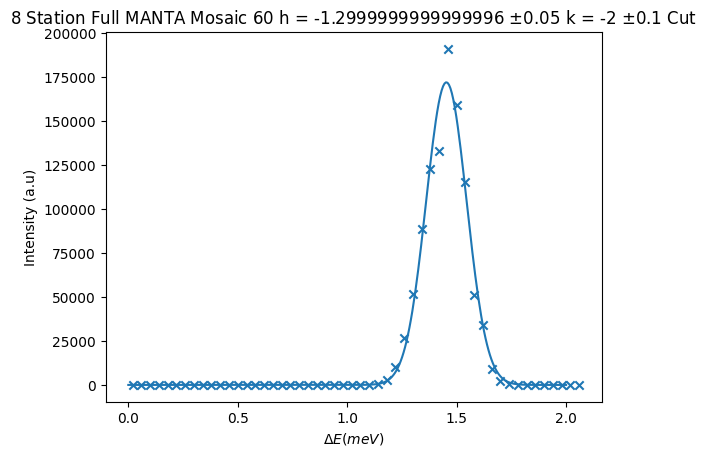

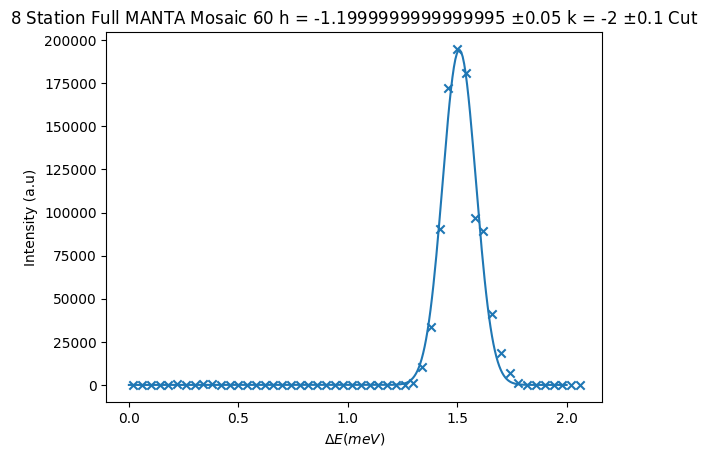

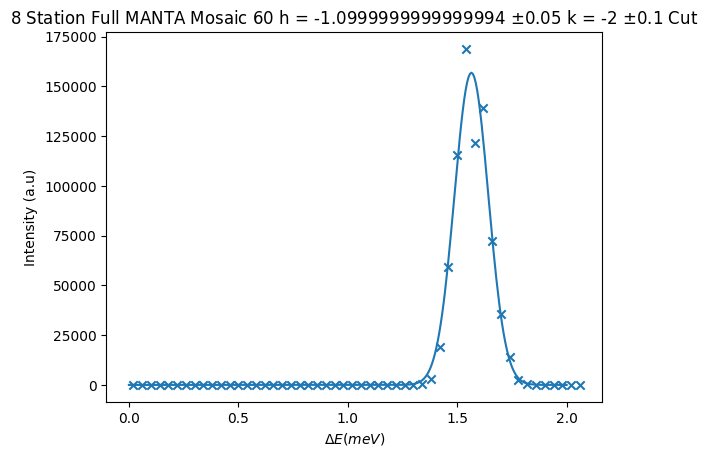

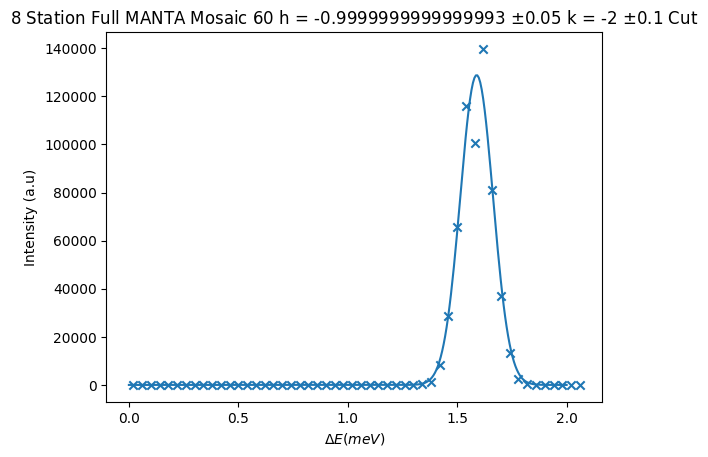

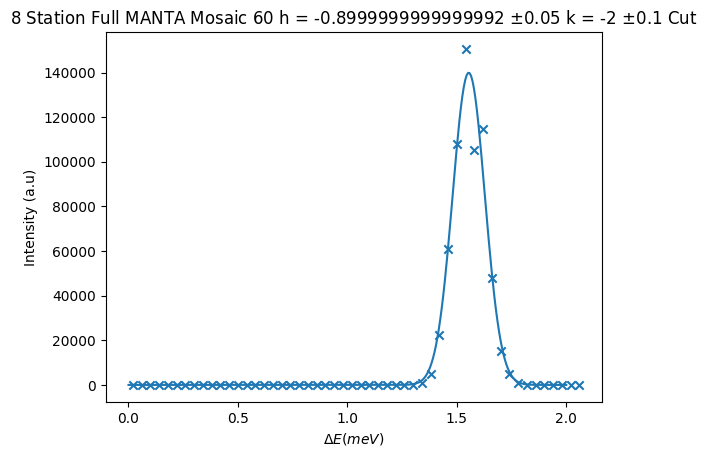

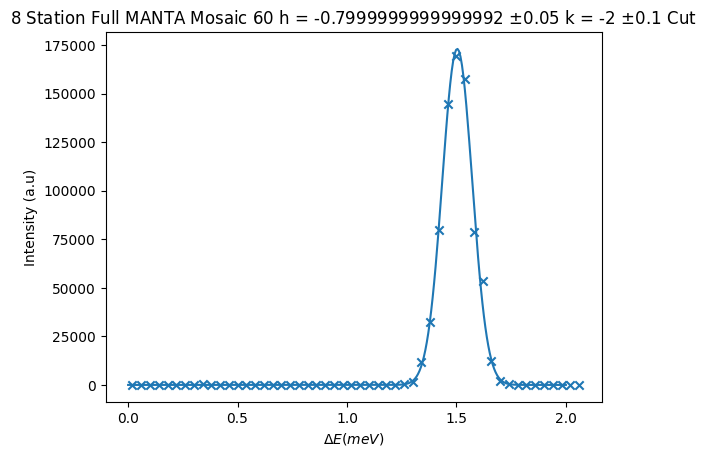

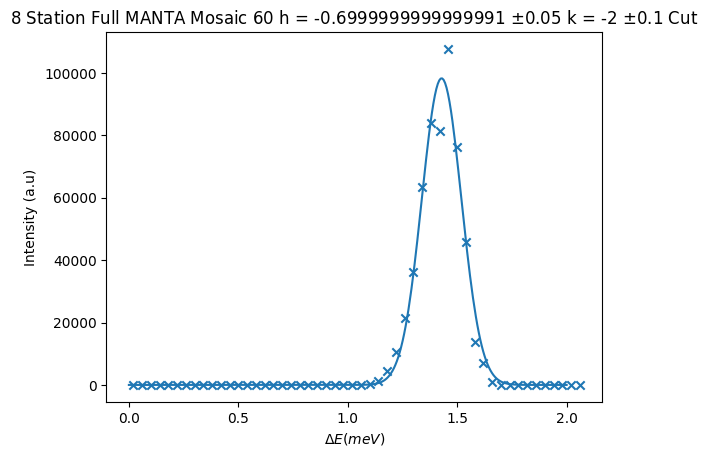

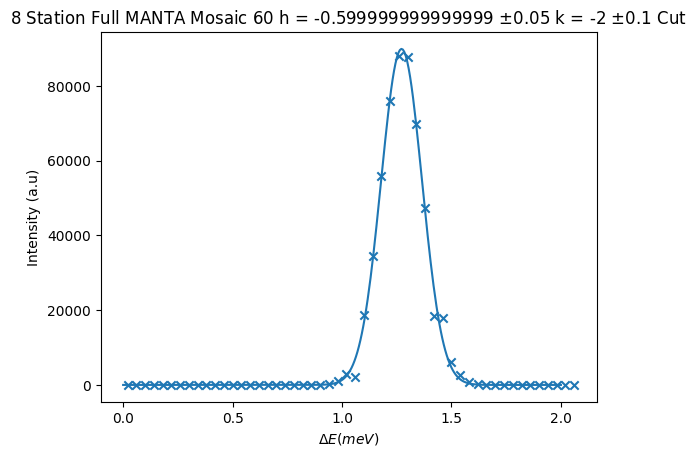

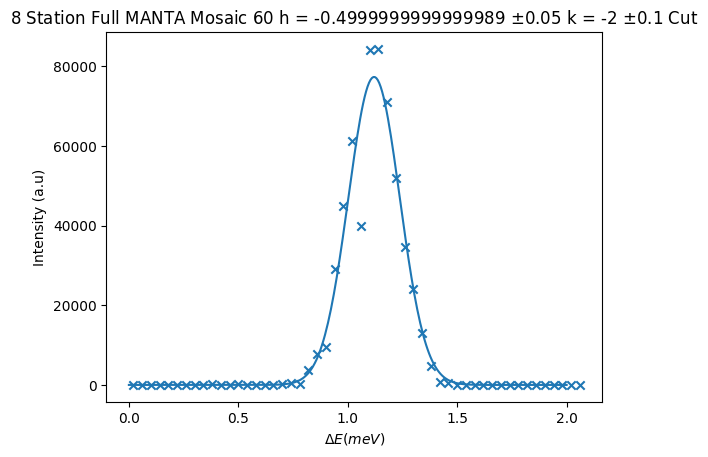

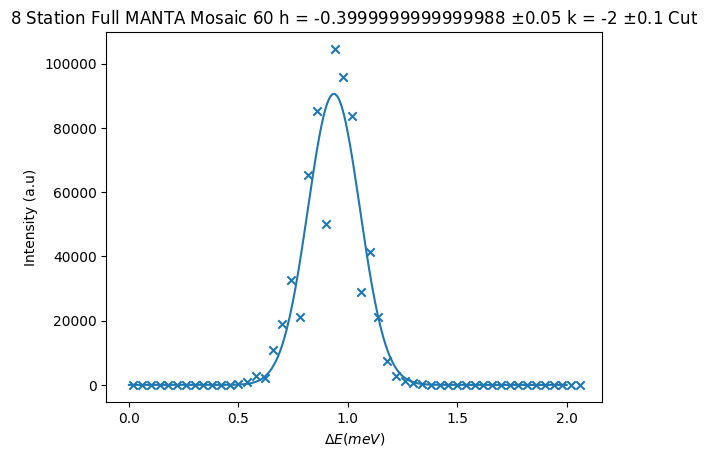

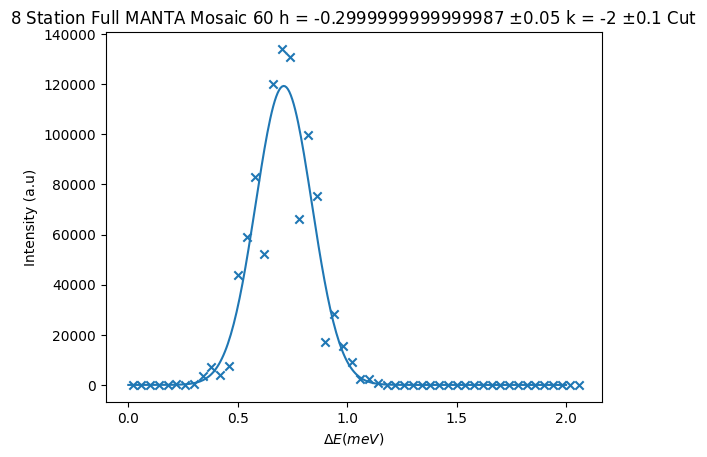

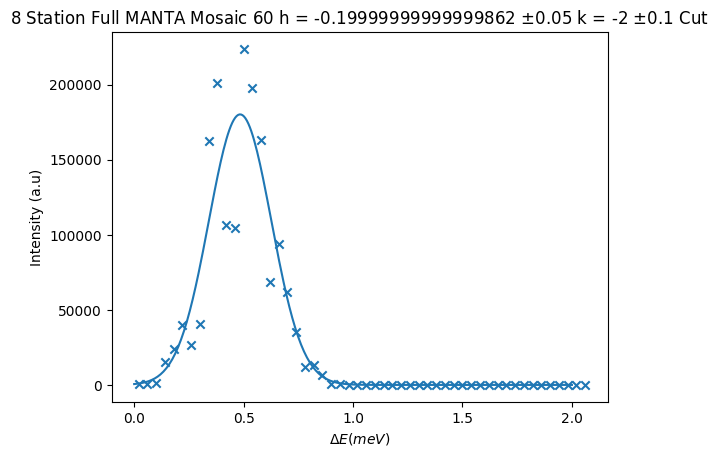

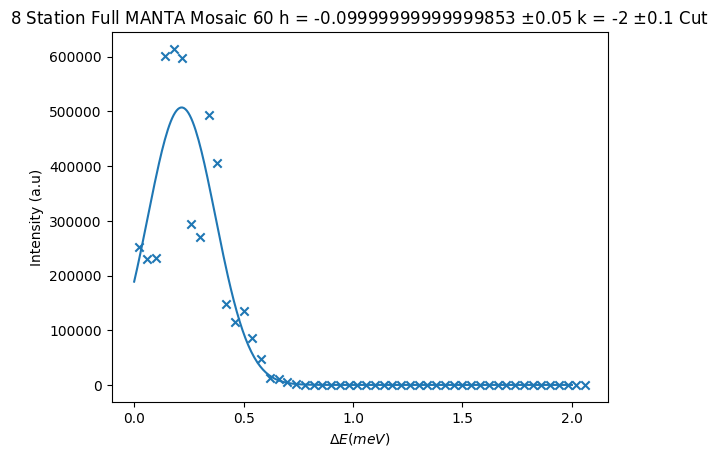

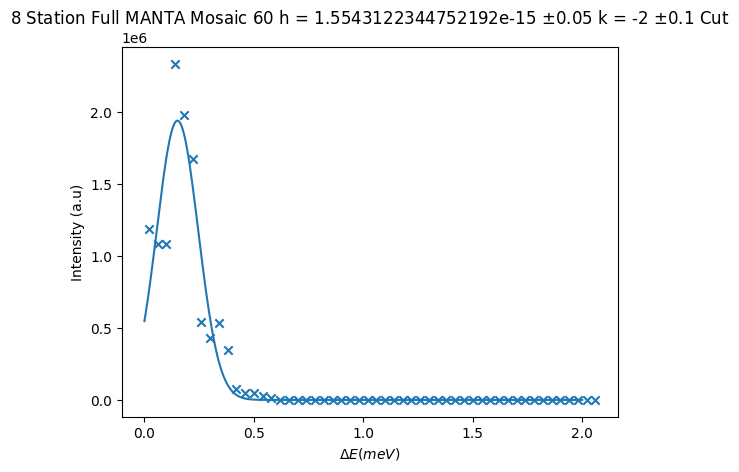

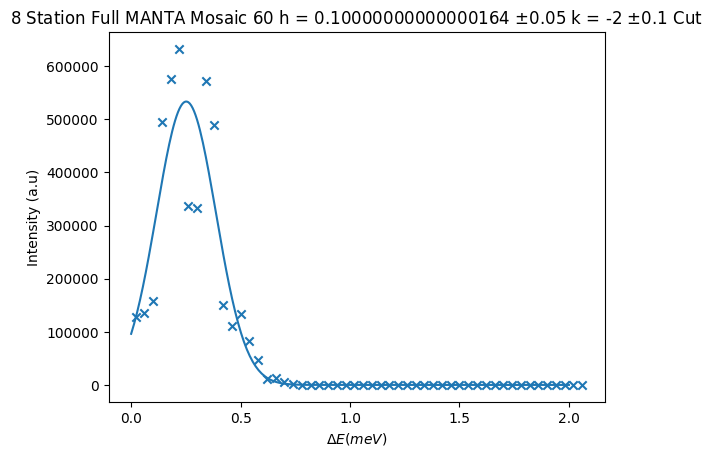

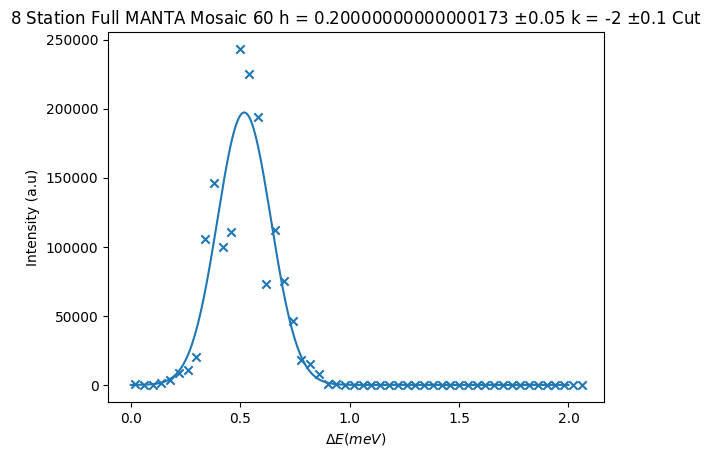

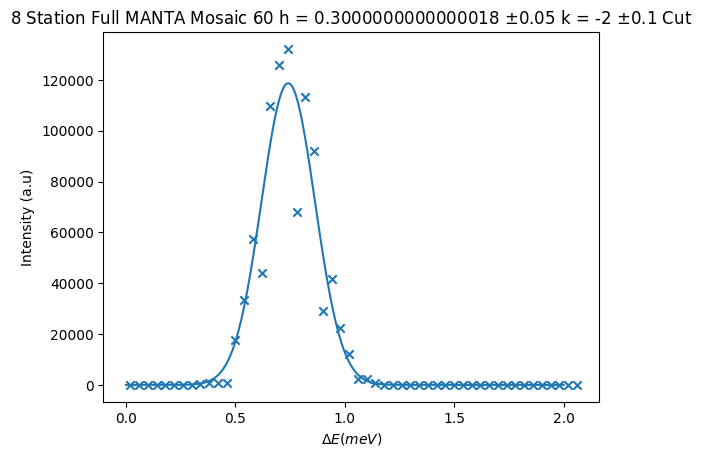

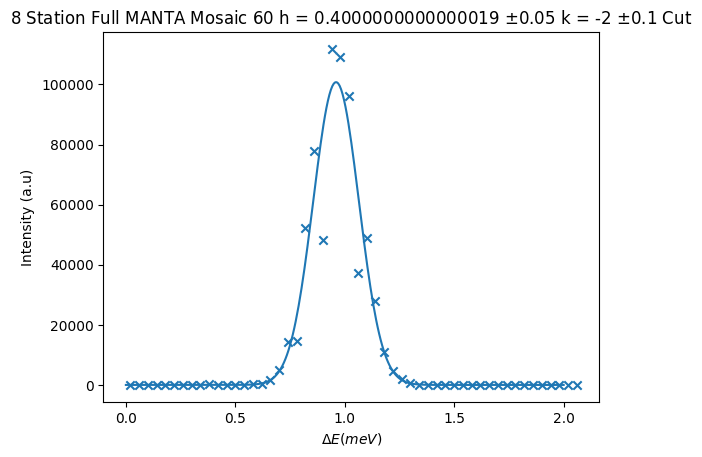

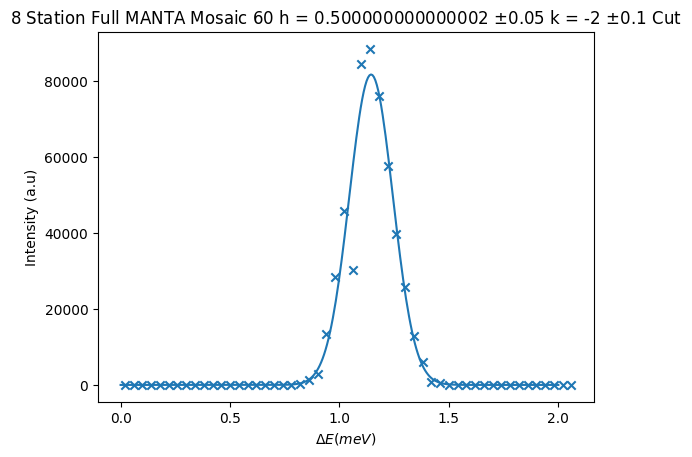

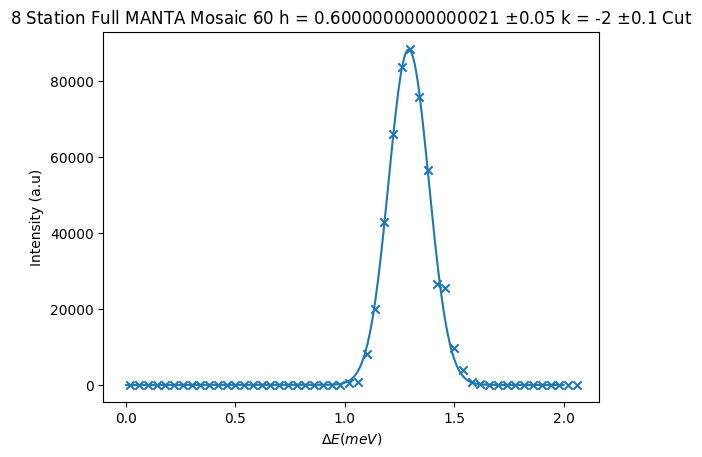

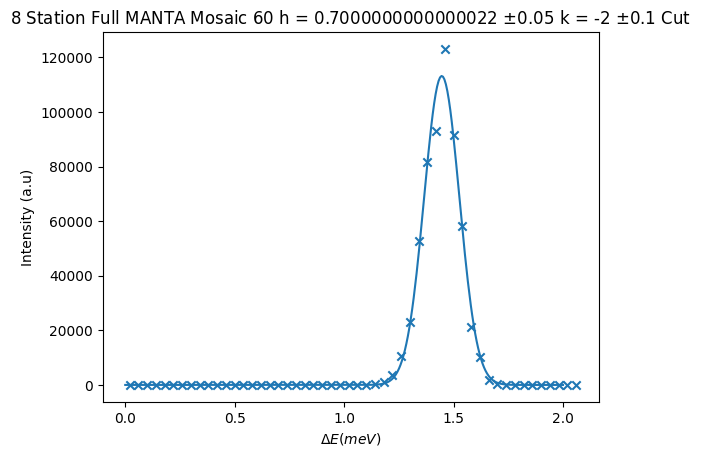

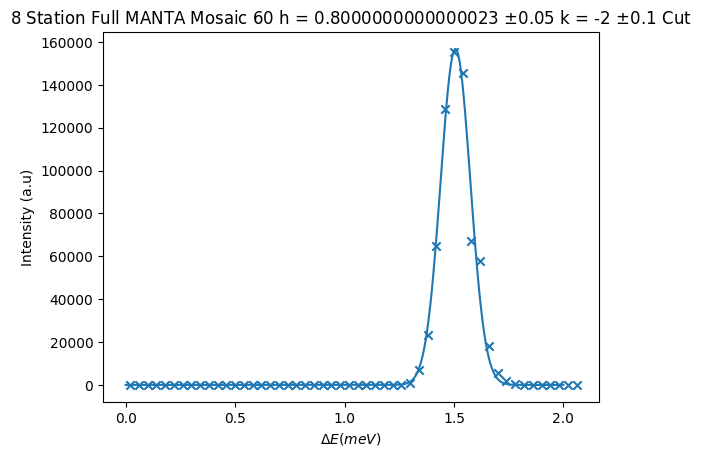

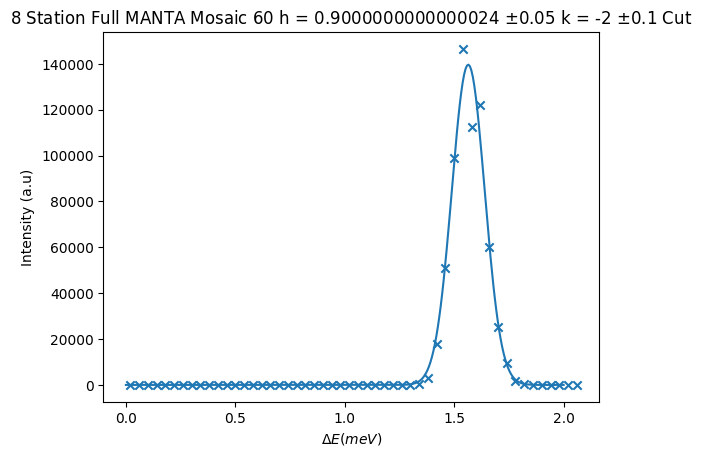

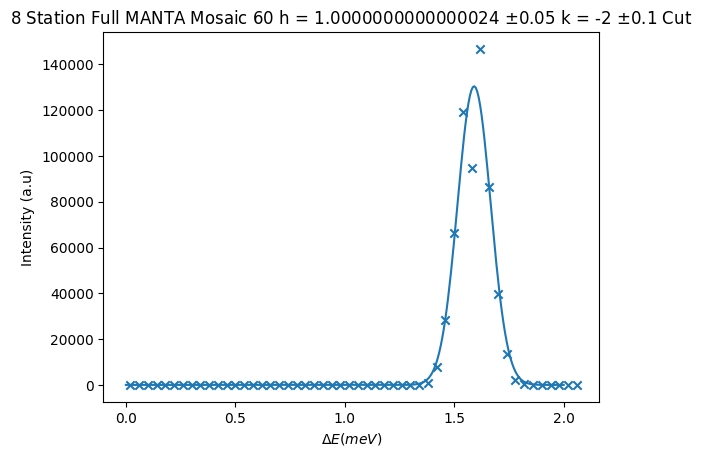

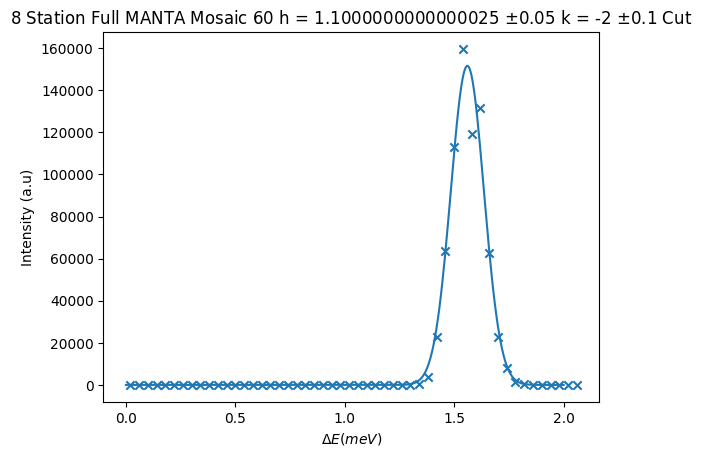

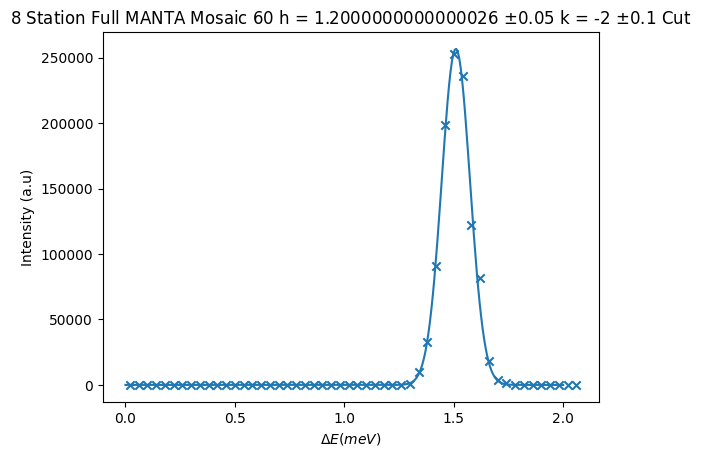

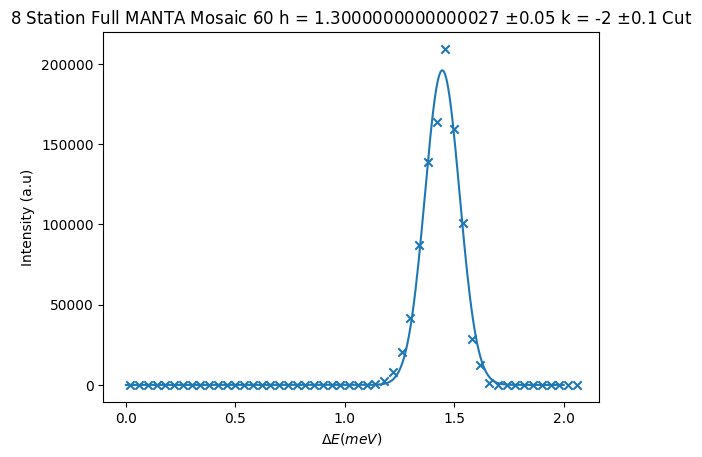

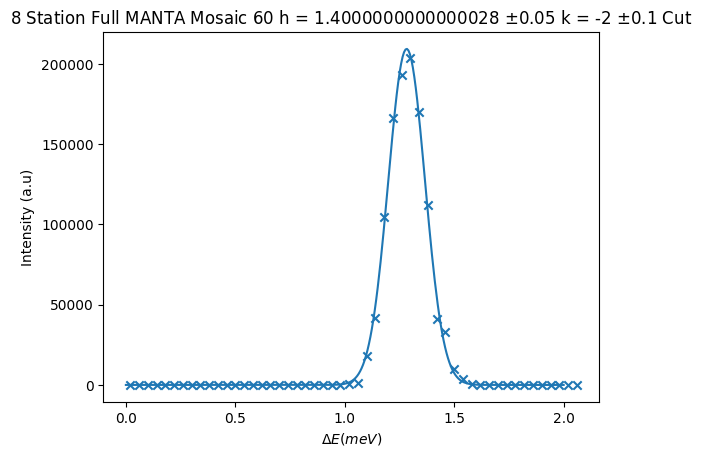

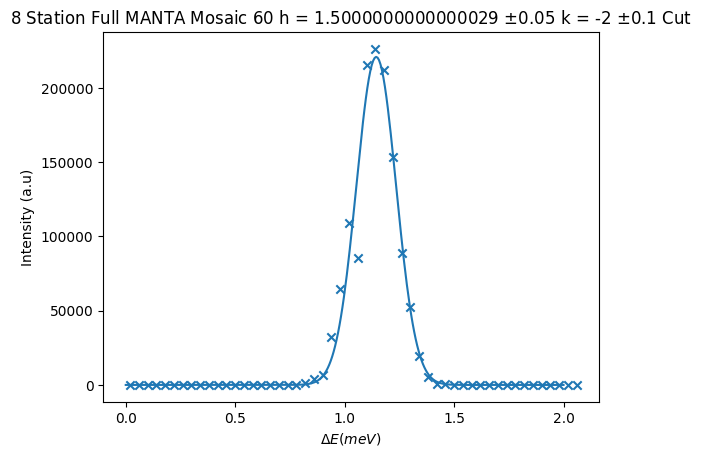

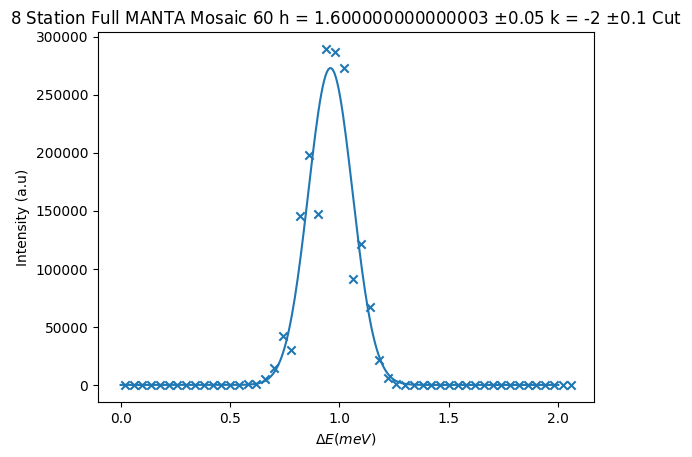

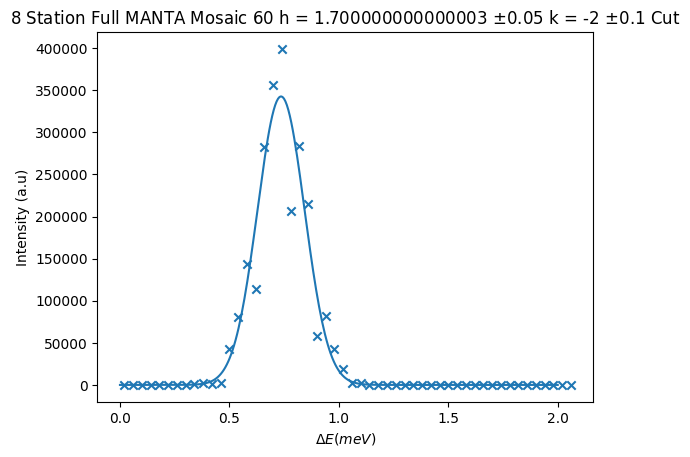

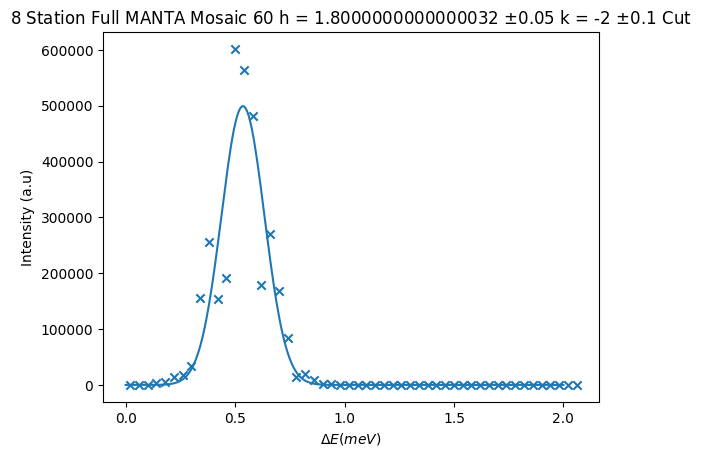

In [27]:
#sliceGenerator("Etransferred", 1.89)
#sliceGenerator("Etransferred", 1.72)
#sliceGenerator("Etransferred", 0.7)
#sliceGenerator1D("Qx", "N/A", 1, 1.3)



xvals = []
yvals = []
for num in np.arange(-1.8, 1.81, 0.1):
    xvals.append(num)
    ypoint = sliceGenerator1D("Etransferred", num, -2, "N/A")['sigma']
    yvals.append(ypoint*2.355)
    

#print(sliceGenerator1D("Etransferred", 0.8, -2, "N/A")['sigma'])

#sliceGenerator("Etransferred", 1.)
#sliceGenerator("Etransferred", 1.05)
#sliceGenerator("Etransferred", 0.77)
#sliceGenerator("Etransferred", 0.46)
#sliceGenerator("Etransferred", 0.09)

[0.36165141 0.3581251  0.31581269 0.29453899 0.27930393 0.21789669
 0.17912687 0.18273523 0.1762296  0.17347639 0.16115708 0.2127947
 0.22050339 0.27705904 0.27916123 0.30211952 0.33620772 0.36344288
 0.22334021 0.32005845 0.28815012 0.2885178  0.24580932 0.23478791
 0.21630132 0.18979688 0.15982939 0.17689597 0.17820481 0.17861675
 0.15244191 0.18631251 0.19776099 0.21411156 0.23849614 0.25346698
 0.23154097]


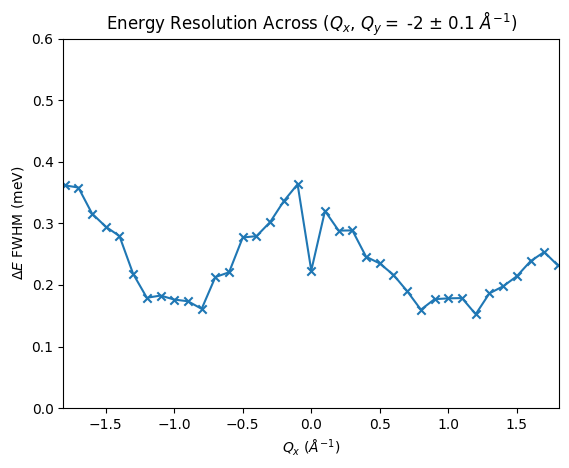

In [28]:
yvals = np.array(yvals)
print(yvals)
plt.scatter(xvals, yvals, marker  = "x")
plt.plot(xvals, yvals)
plt.xlim(-1.81, 1.81)
plt.ylim(0, 0.6)
#print(yvals)
plt.xlabel("$Q_x$ $(\AA^{-1})$")
plt.ylabel("$\Delta E$ FWHM (meV)")
plt.title("Energy Resolution Across ($Q_x$, $Q_y = $ -2 $\pm$ 0.1 $\AA^{-1}$)")
plt.show()

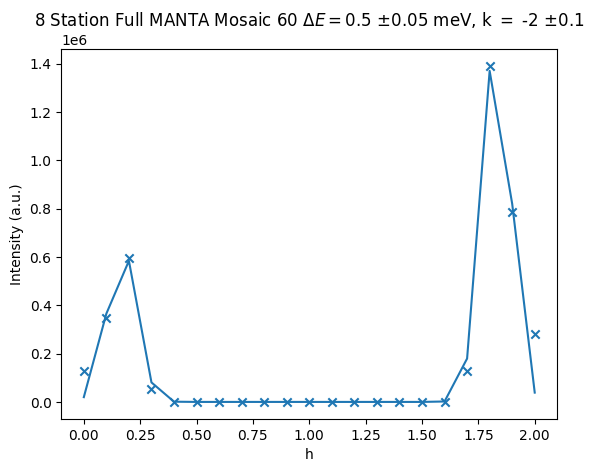

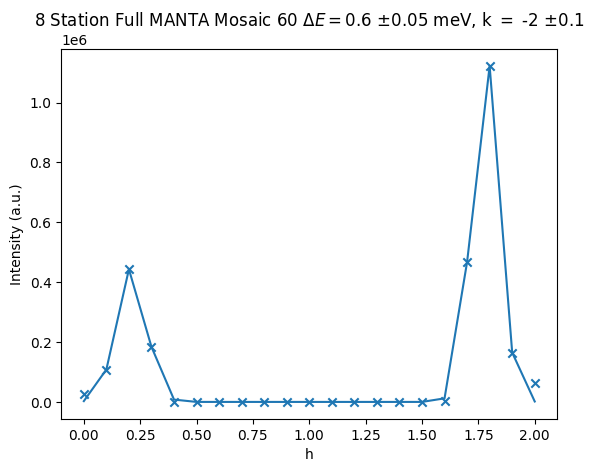

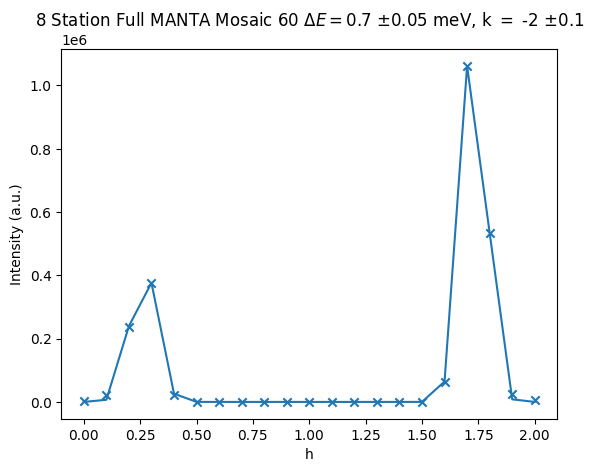

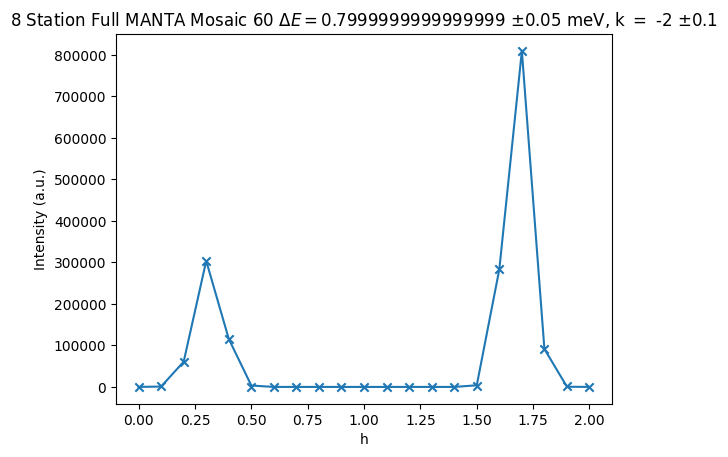

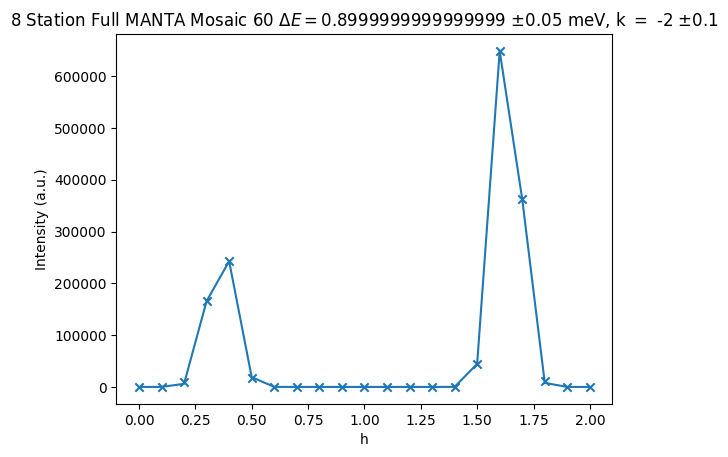

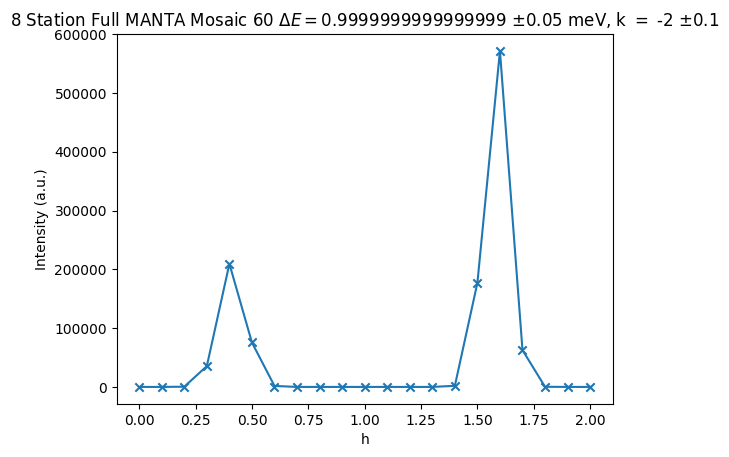

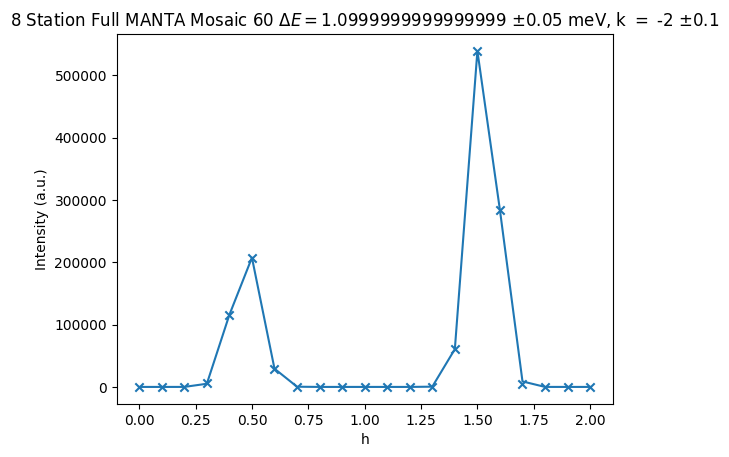

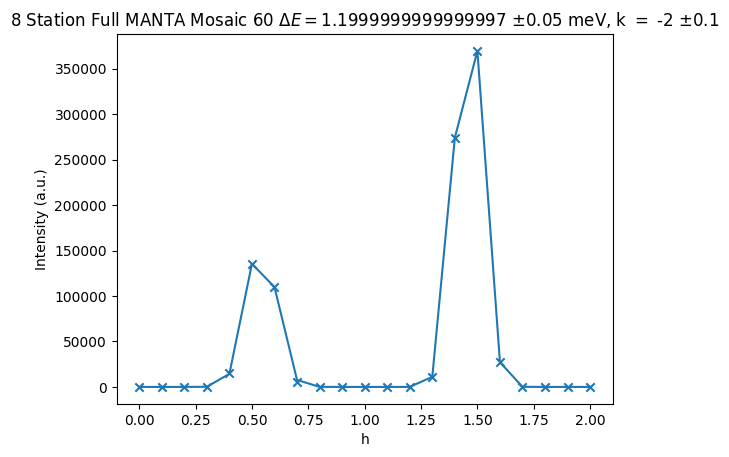

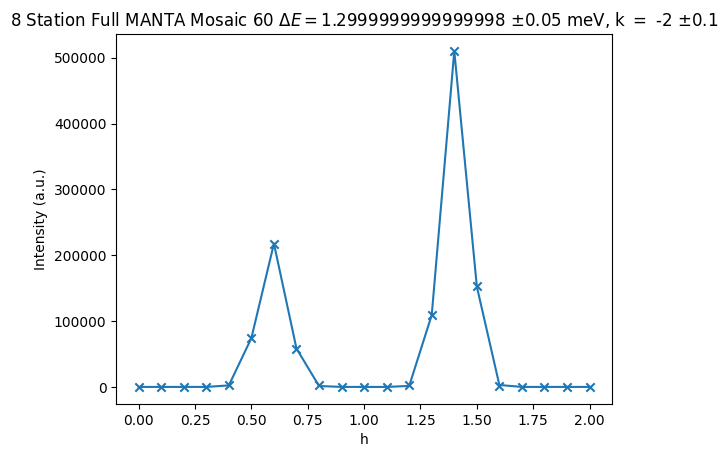

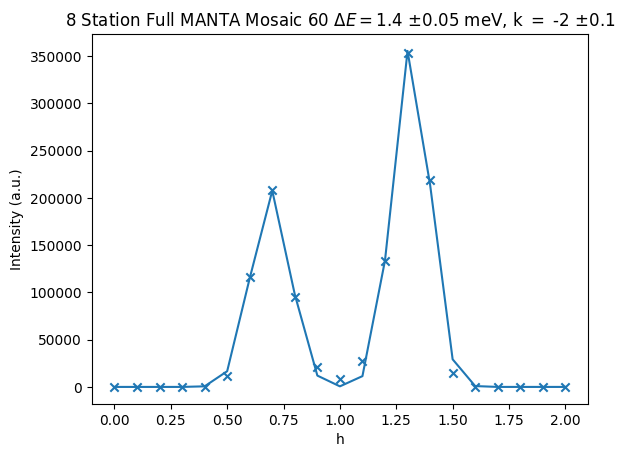

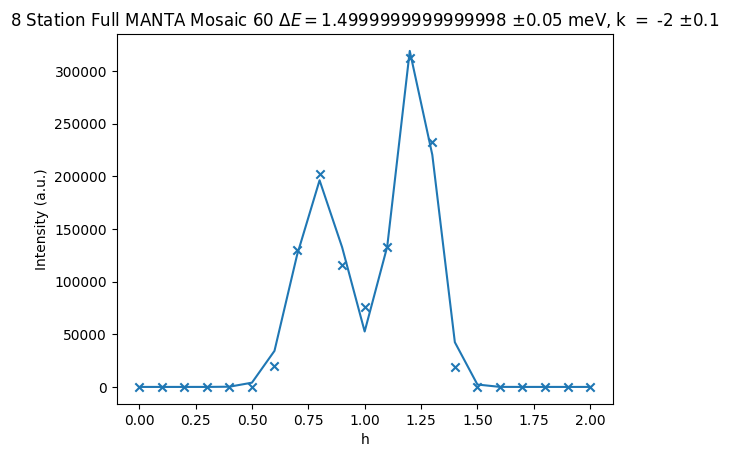

In [13]:
xvals = []
neg1s = []
pos1s = []
for num in np.arange(0.5, 1.51, 0.1):
    xvals.append(num)
    values = sliceGenerator1D("Qx", "N/A", -2, num)
    g1Val = values['g1_sigma'] * 2.355
    g2Val = values['g2_sigma'] * 2.355
    if values['g1_center'] < 1.0:
        neg1s.append(g1Val)
    else:
        pos1s.append(g1Val)
    if values['g2_center'] < 1.0:
        neg1s.append(g2Val)
    else:
        pos1s.append(g2Val)


[0.1505012674970189, 0.15568092706386205, 0.13325253894955694, 0.14676304793688993, 0.1374918703870882, 0.14081147732139548, 0.14772379185291745, 0.15028277925840405, 0.15221779891670306, 0.20311049420529523, 0.2561468705934774]


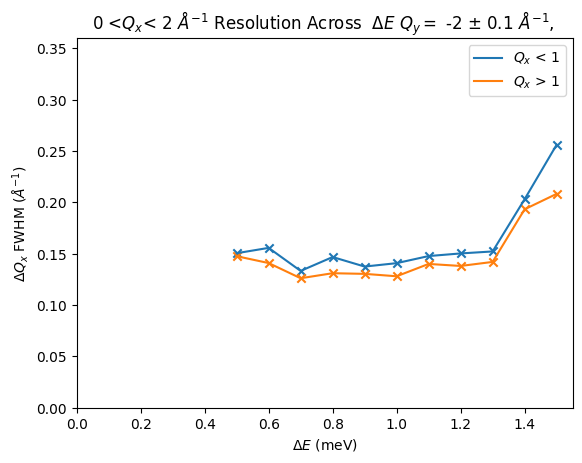

In [14]:
print(neg1s)
#print(pos1s)
plt.scatter(xvals, neg1s, marker  = "x")
plt.scatter(xvals, pos1s, marker = "x")
plt.plot(xvals, neg1s, label="$Q_x$ < 1")
plt.plot(xvals, pos1s, label = "$Q_x$ > 1")
plt.xlim(0.0, )
plt.ylim(0, 0.36)
#print(yvals)
plt.xlabel("$\Delta E$ (meV)")
plt.legend()
plt.ylabel("$\Delta Q_x$ FWHM $(\AA^{-1})$")
plt.title("0 <$Q_x$< 2 $\AA^{-1}$ Resolution Across  $\Delta E$ $Q_y = $ -2 $\pm$ 0.1 $\AA^{-1}$, ")
plt.show()

File exists! Pick a new name


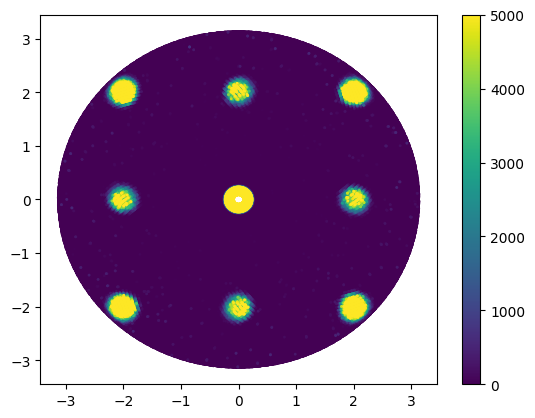

C:\Users\Administrator\AppData\Local\Temp\ipykernel_16736\2032739811.py:346: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interp.interp2d(x, y, finallist)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_16736\2032739811.py:347: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new

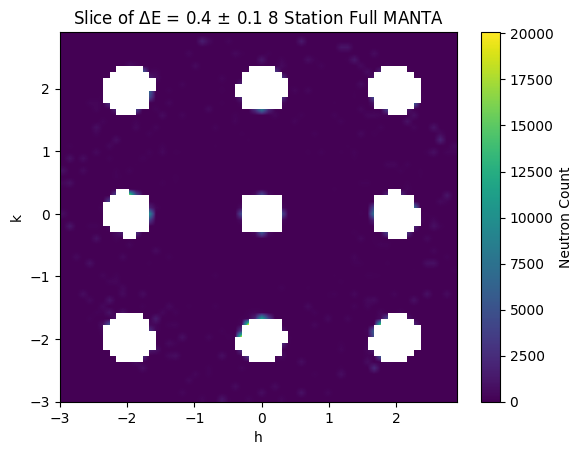

File exists! Pick a new name


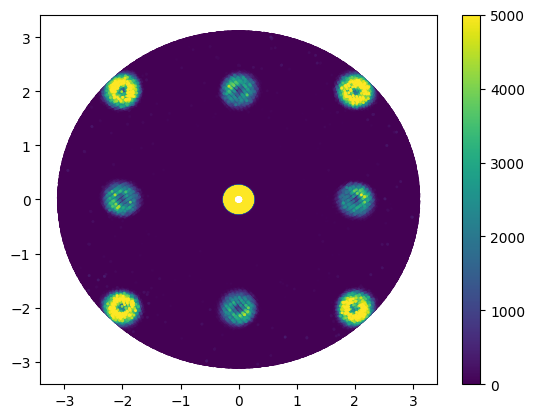

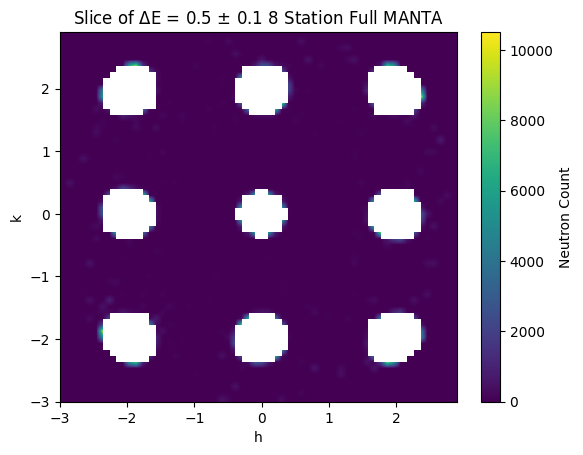

File exists! Pick a new name


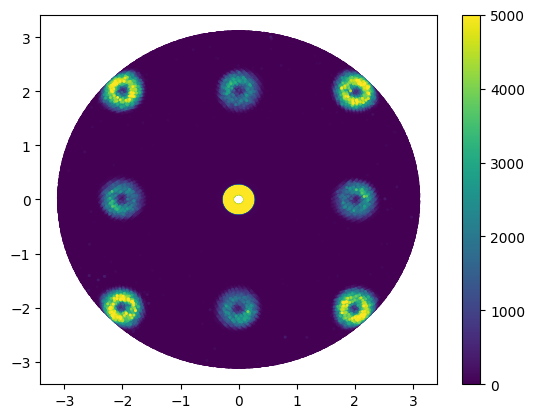

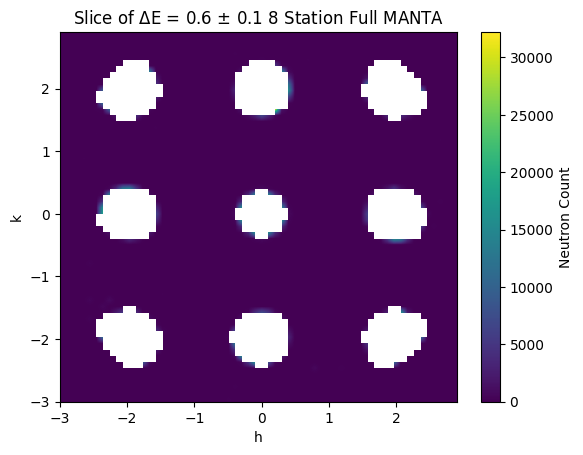

File exists! Pick a new name


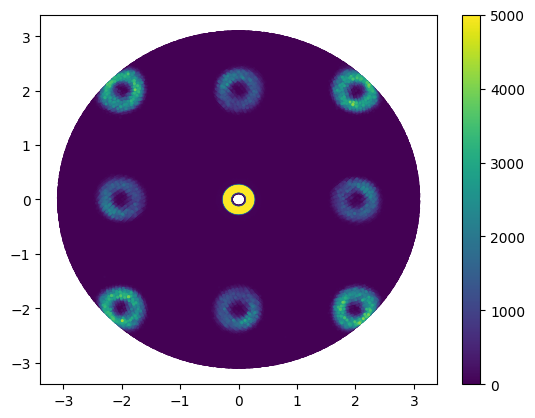

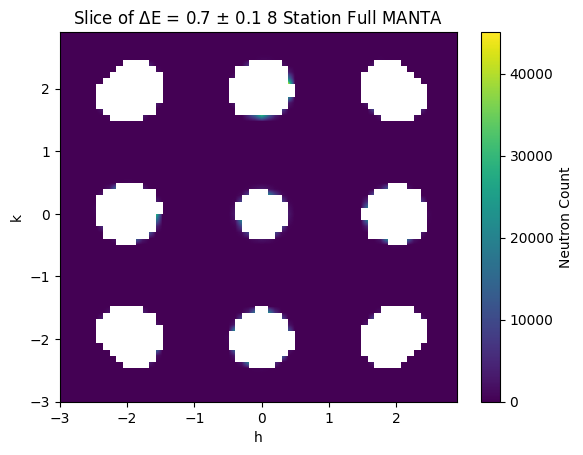

File exists! Pick a new name


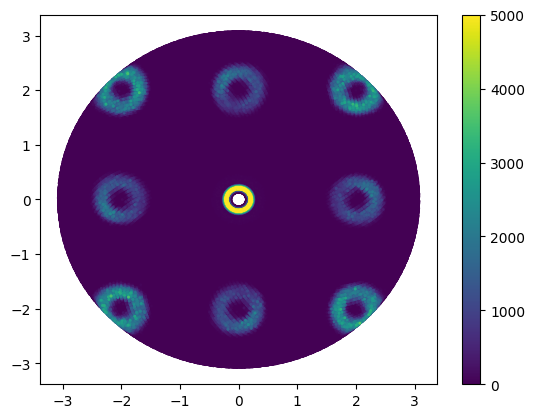

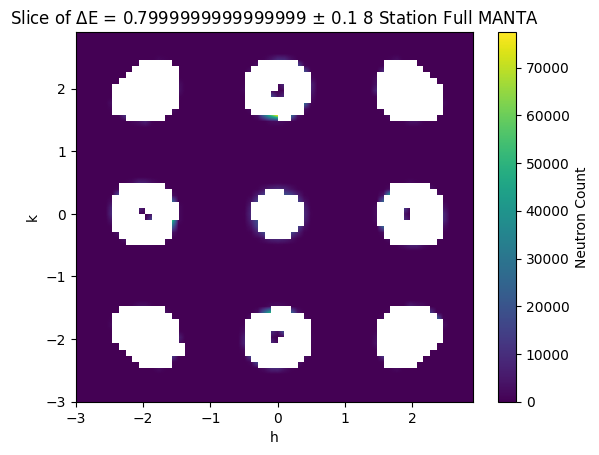

File exists! Pick a new name


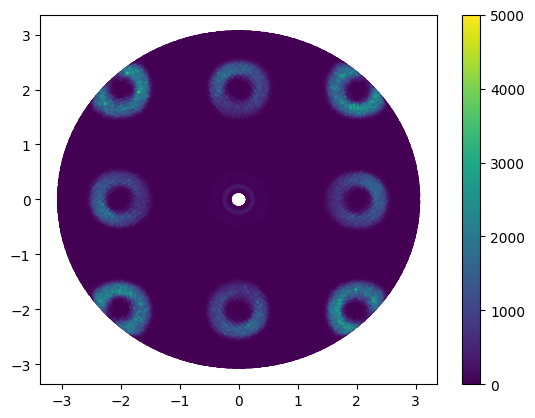

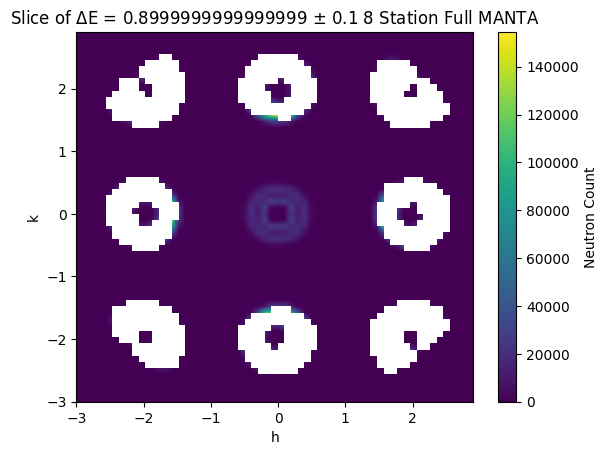

File exists! Pick a new name


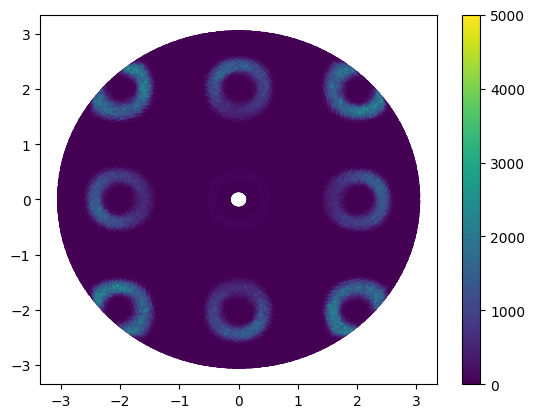

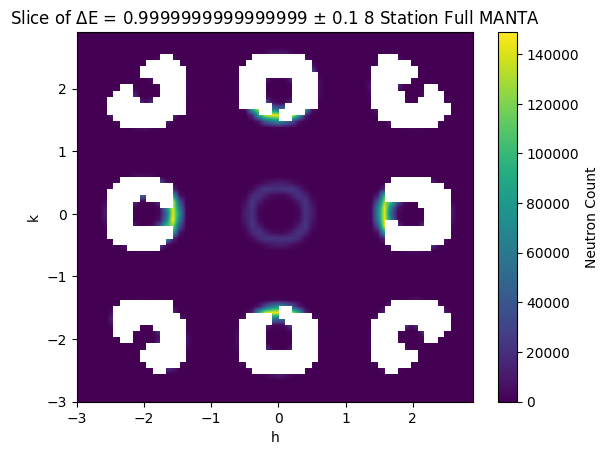

File exists! Pick a new name


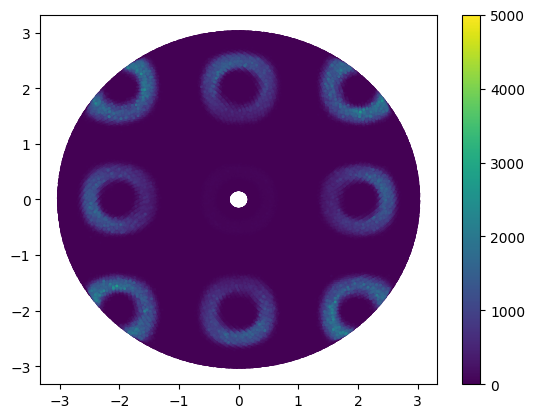

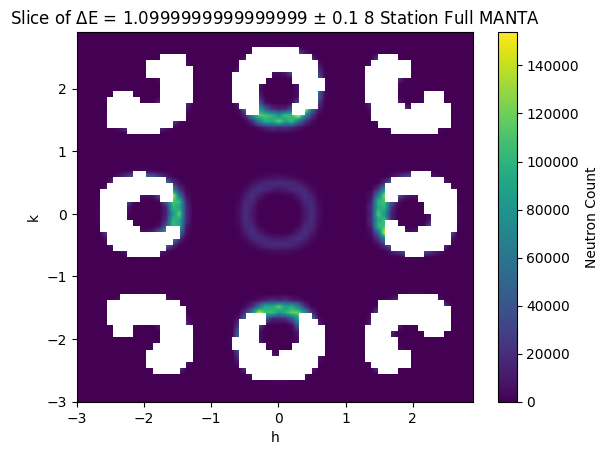

File exists! Pick a new name


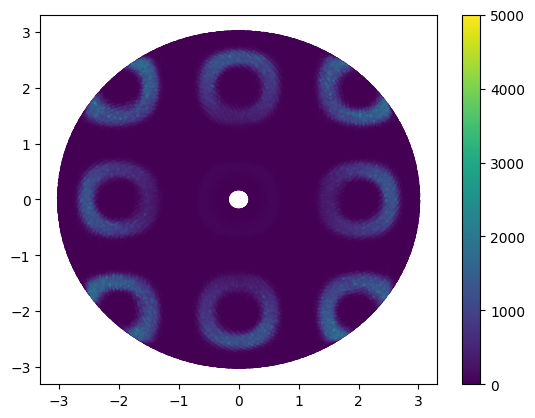

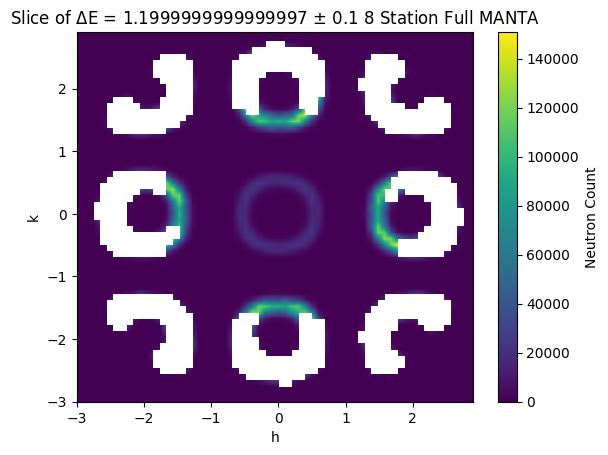

File exists! Pick a new name


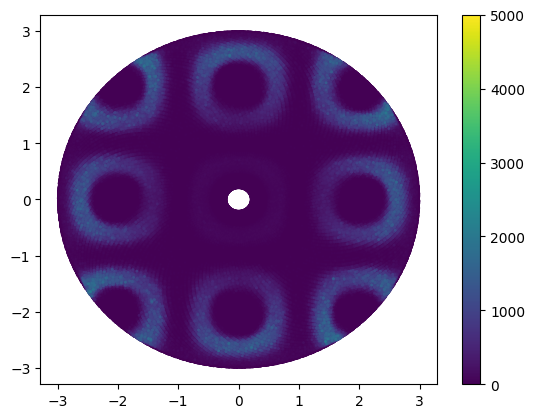

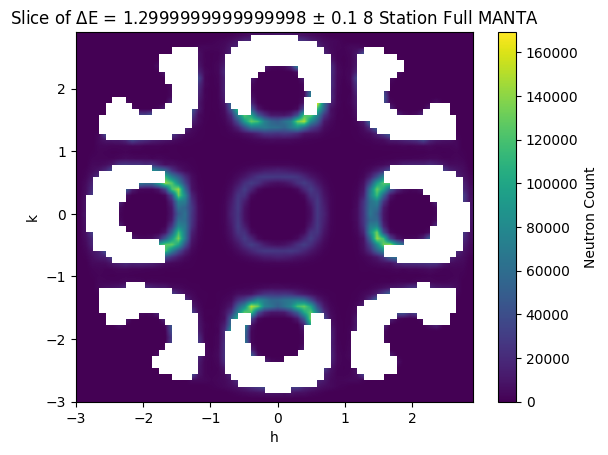

File exists! Pick a new name


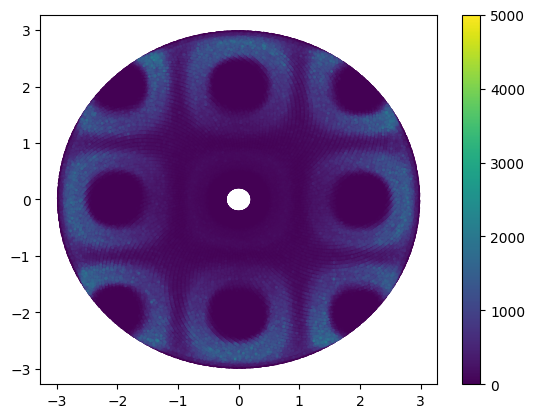

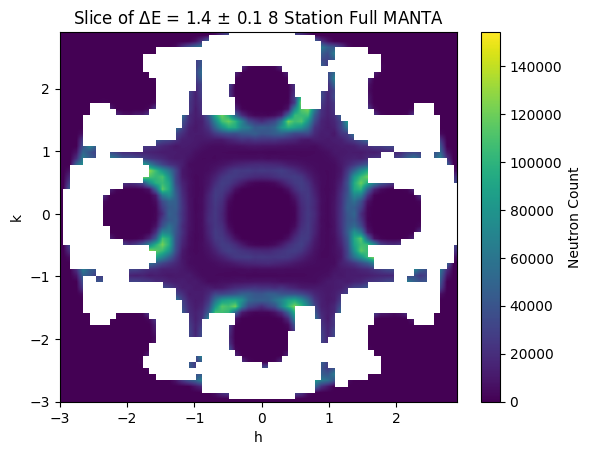

File exists! Pick a new name


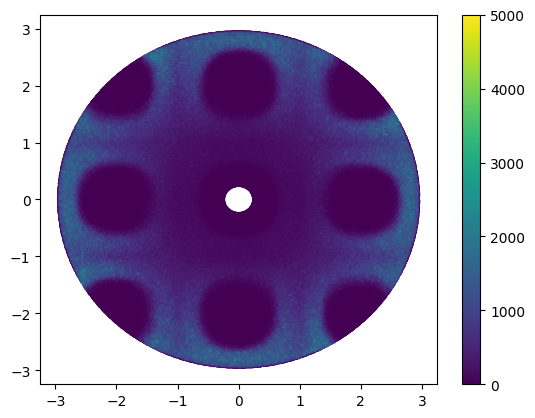

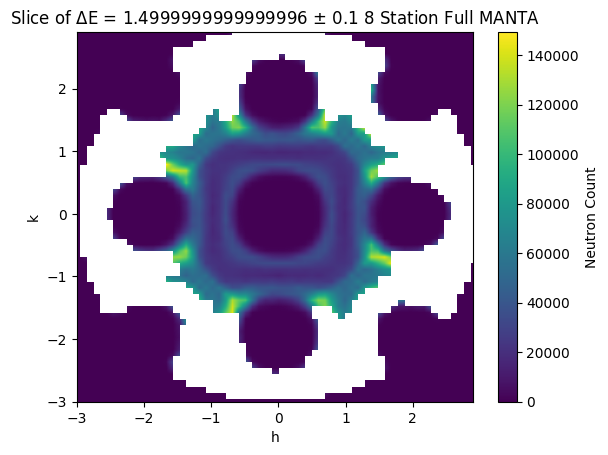

File exists! Pick a new name


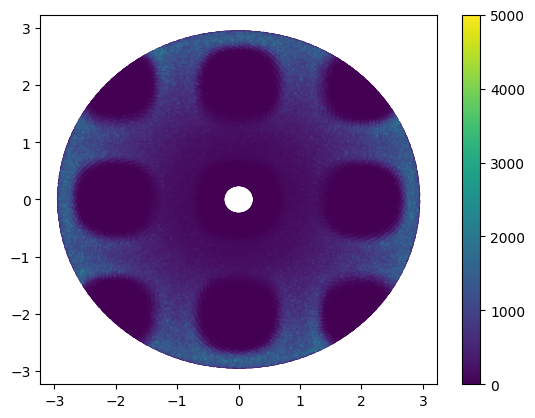

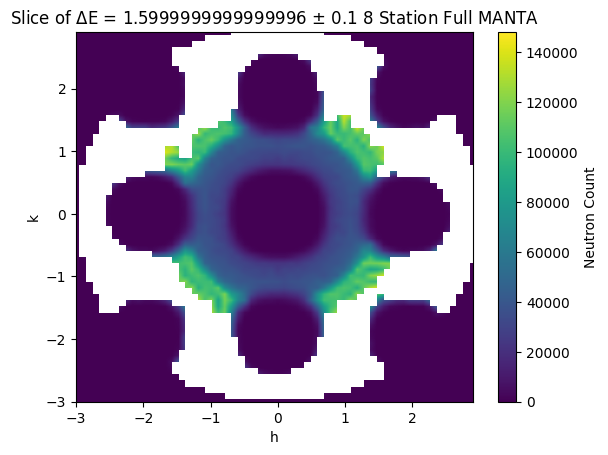

File exists! Pick a new name


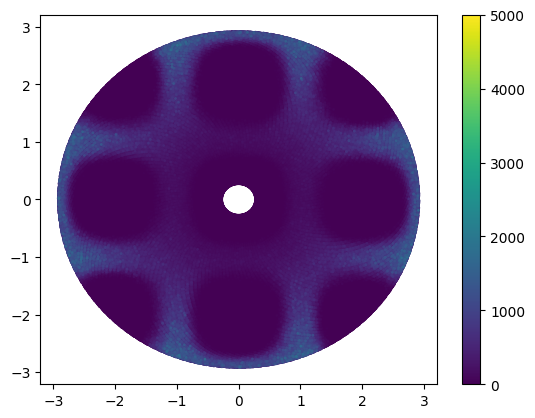

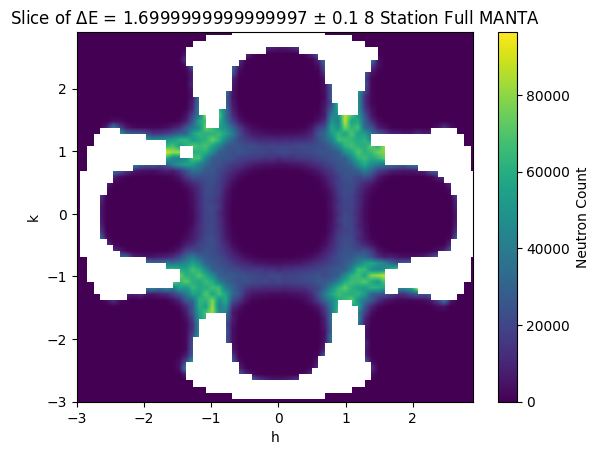

In [13]:
import imageio
def create_frame(frame):
    fig = plt.figure()
    tupl = sliceGenerator("Etransferred", frame, width = 0.1)

    if tupl == None:
        print("HIII")
        print(frame)
    #plot.set_Data((xboys, yboys, zboys))
    else:
        xboys, yboys, zboys = tupl
        plt.scatter(xboys, yboys, c= zboys, vmax = 5000, vmin = 0, s=1)
    plt.ylabel("$k$")
    plt.xlabel("$h$")
    plt.xlim(-3.2, 3.2)
    plt.ylim(-3.2,3.2)
    plt.title(r"Phonon Dispersion (h,  k, 0) $\Delta E = $"  + str(round(frame, 1)) + " $\pm 0.05$ meV")
    plt.colorbar(label="Neutron Count")
    plt.savefig(f'D:/Users/Adit/Figures/img_{round(frame, 1)}.png', transparent =False, facecolor = 'white')
    plt.close()
e = np.arange(0.4, 1.8, 0.1)
for frame in e:
    create_frame(frame)
frames = []
for frame in e:
    image = imageio.v2.imread(f'D:/Users/Adit/Figures//img_{round(frame, 1)}.png')
    frames.append(image)
imageio.mimsave('D:/Users/Adit/Figures/example.gif', frames, duration=500)

In [ ]:
plot = plt.scatter([])
figure = plt.figure()
from matplotlib.animation import FuncAnimation
from IPython import display
def AnimationFunction(frame):
    tupl = sliceGenerator("Qy", frame)
    xboys, yboys, zboys, = tup1
    plot.set_Data((xboys, yboys, zboys))
    #plt.scatter(xboys, yboys, c= zboys, vmax = 70
    #plt.ylabel("${\Delta}$E")
    #plt.xlabel("Qx " + r'$\AA$')
    #plt.title(r"Slice of (h,  " + str(frame) + ", 0) MANTA)
    #plt.colorbar(lbel="Neutron Count")
anim_Created = FuncAnimation(figure, AnimationFunction, frames = 15, interval = 0.1)
video = anim_created.to_html5_Video()
html = display.HTML()
display.display(html)